In [1]:
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
import sys 
import pandas as pd
import os
import optuna
import matplotlib.pylab as plt
%matplotlib inline
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from torchcontrib.optim import SWA
from pytorch_lightning import Trainer, seed_everything
from argparse import ArgumentParser
sys.path.append('../data/ml_mmrf')
sys.path.append('../data/synthetic')
sys.path.append('../data/semi_synthetic')
sys.path.append('../ief_core/')
from ml_mmrf.ml_mmrf_v1.data import load_mmrf
from synthetic_data import load_synthetic_data_trt, load_synthetic_data_noisy
from ss_data import *
from models.ssm.ssm import SSM, SSMAtt
from models.ssm.ssm_baseline import SSMBaseline
from models.rnn import GRU
from models.utils import *
print(torch.__version__)

1.6.0


In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from utilities.helper_viz import get_scolor

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

In [3]:
from ml_mmrf_v1.data import load_mmrf

# Semi-Synthetic Data

In [7]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device  = torch.device('cpu')
fname = '../ief_core/tests/checkpoints/ssm_semi_syn_moe_20000sample_complexityepoch=00989-val_loss=-323.60.ckpt'

checkpoint = torch.load(fname, map_location=lambda storage, loc: storage)
hparams    = checkpoint['hyper_parameters']
del hparams['trial']
print({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
model = SSM(trial, **hparams); model.setup(1)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
print(model.hparams.ss_in_sample_dist)
print(model.hparams.ss_missing)
ddata = load_ss_data(1000, gen_fly=True, eval_mult=200, in_sample_dist=model.hparams.ss_in_sample_dist, add_missing=model.hparams.ss_missing)
print(f'eval set size: {ddata["valid"][0]["X"].shape}')
nelbos = []
for i in range(1,5):
    _, valid_loader = load_ss_helper(ddata, tvt='valid', bs=model.hparams['bs'], device=device, valid_fold=i)
    batch_nelbos = []
    for i_batch, valid_batch_loader in enumerate(valid_loader):
        (nelbo, nll, kl, _), _ = model.forward(*valid_batch_loader, anneal = 1.)
        nelbo, nll, kl         = nelbo.item(), nll.item(), kl.item()
        batch_nelbos.append(nelbo)
    # (nelbo, nll, kl, _), _ = model.forward(*valid_loader.dataset.tensors, anneal = 1.)
    nelbos.append(np.mean(batch_nelbos))
print(f'[COMPLETE] mean nelbo: {np.mean(nelbos)}, std nelbo: {np.std(nelbos)}')

True
{'bs': 1500, 'lr': 0.001, 'C': 0.01, 'reg_all': True, 'reg_type': 'l2', 'dim_stochastic': 128}
generating semi synthetic data...
using relu in inf. network
loading /afs/csail.mit.edu/u/z/zeshanmh/research/trvae/dmm/good_models/sota_ssm_mm.pt
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 35.81666666666667
20 19 20
using digitized y
using digitized y
using digitized y
sampling from SSM model trained on MM data...
shape of training data:(20000, 20, 16)
using relu in inf. network
True
False
generating semi synthetic data...
using relu in inf. network
loading /afs/csail.mit.edu/u/z/zeshanmh/research/trvae/dmm/good_models/sota_ssm_mm.pt
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 35.81666666666667
20 19 20
using digitized y
using digitized y
using digitized y
sampling from SSM model trained on MM data...
eval se

# Synthetic Data

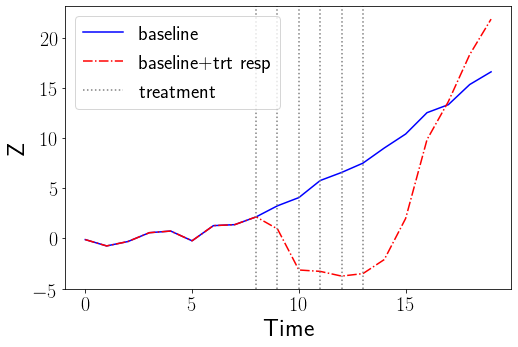

In [126]:
from numpy.polynomial.polynomial import polyval
np.random.seed(0)
def g(v, params=None): 
    if params is not None: 
        a1, a2, a3, b, gamma = params 
    else: 
        a1 = 5; a2 = 0.3; a3 = 0.4; b = 2; gamma = 40.
    b0 = -a1 / (1 + np.exp(a2*gamma / 2))
    a0 = (a1 + 2*b0 - b) / (1 + np.exp(-a3*gamma/2))
    if v < gamma: 
        return b0 + a1 / (1 + np.exp(-a2*(v-(gamma/2))))
    else: 
        return b + a0 / (1 + np.exp(a3*(v-(3*gamma)/2)))
params = [-15, 0.7, 0.4, 2, 3]
params2 = [5, 0.1, 0.3, 2, 2]
Xvals = np.arange(20)
up    = [-2, 0.0002, 0.1]
res   = np.array([polyval(val,up) for val in Xvals]) 
res   = 0.5*res+0.5*np.random.randn(*res.shape)
rx_t  = np.arange(8,14)
res_copy = np.copy(res)
for t in rx_t: 
    re = np.arange(Xvals.shape[0] - t)
    add = np.array([g(v,params) for v in re])
    res_copy[np.arange(t,Xvals.shape[0])]+= add
fig, ax = plt.subplots(figsize=(8,5.2))
ax.plot(Xvals, res, color='blue', linestyle='-', label='baseline')
ax.plot(Xvals, res_copy, color='red', linestyle='-.', label='baseline+trt resp')
for t in range(len(rx_t)): 
    if t == 0:
        ax.axvline(rx_t[t], linestyle=':', color='grey', label='treatment')
    else: 
        ax.axvline(rx_t[t], linestyle=':', color='grey')
#            ax.set_xlabel('Time', fontsize=18)
ax.tick_params(labelsize=20)
ax.set_xlabel('Time', fontsize=25)
ax.set_ylabel('Z', fontsize=25)
ax.legend(fontsize=20)
# plt.title('Baseline Progression w/ Superimposed Treatment Response', fontsize=15, pad=15)
fig.savefig('./plots/aaai-plots/treatment_exp_syn.pdf', bbox_inches='tight')

In [8]:
nsamples        = {'train':100, 'valid':1000, 'test':50000}
folds           = [0,1,2,3,4]
alpha_1_complex = False; per_missing = 0.; add_feat = 0; num_trt = 1
ddata = load_synthetic_data_trt(fold_span = folds, \
                                nsamples = nsamples, \
                                distractor_dims_b=4, \
                                sigma_ys=0.7, \
                                include_line=True, \
                                alpha_1_complex=alpha_1_complex, \
                                per_missing=per_missing, \
                                add_feats=add_feat, \
                                num_trt=num_trt, \
                                sub=True)

In [9]:
def setup_torch_dataset(ddata, fold, tvt, device=None, oversample=True, att_mask=False, batch_size=600):
    if device is not None: 
        B  = torch.from_numpy(ddata[fold][tvt]['b'].astype('float32')).to(device)
        X  = torch.from_numpy(ddata[fold][tvt]['x'].astype('float32')).to(device)
        A  = torch.from_numpy(ddata[fold][tvt]['a'].astype('float32')).to(device)
        M  = torch.from_numpy(ddata[fold][tvt]['m'].astype('float32')).to(device)
    else: 
        B  = torch.from_numpy(ddata[fold][tvt]['b'].astype('float32'))
        X  = torch.from_numpy(ddata[fold][tvt]['x'].astype('float32'))
        A  = torch.from_numpy(ddata[fold][tvt]['a'].astype('float32'))
        M  = torch.from_numpy(ddata[fold][tvt]['m'].astype('float32'))

    y_vals   = ddata[fold][tvt]['ys_seq'][:,0].astype('float32')
    idx_sort = np.argsort(y_vals)

    if 'digitized_y' in ddata[fold][tvt]:
        print ('using digitized y')
        Y  = torch.from_numpy(ddata[fold][tvt]['digitized_y'].astype('float32'))
    else:
        Y  = torch.from_numpy(ddata[fold][tvt]['ys_seq'][:,[0]]).squeeze()

    if device is not None: 
        Y = Y.to(device)
        CE = torch.from_numpy(ddata[fold][tvt]['ce'].astype('float32')).to(device)
    else: 
        CE = torch.from_numpy(ddata[fold][tvt]['ce'].astype('float32'))

    if att_mask: 
        attn_shape  = (A.shape[0],A.shape[1],A.shape[1])
        Am   = get_attn_mask(attn_shape, ddata[fold][tvt]['a'].astype('float32'), device)
        data = TensorDataset(B[idx_sort], X[idx_sort], A[idx_sort], M[idx_sort], Y[idx_sort], CE[idx_sort], Am[idx_sort])
    else: 
        data = TensorDataset(B[idx_sort], X[idx_sort], A[idx_sort], M[idx_sort], Y[idx_sort], CE[idx_sort])
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    return data, data_loader

In [10]:
sname = {}; models = {}
# sname['syn_ssm_lin'] = '../ief_core/tests/checkpoints/ssm_syn_lin500samp_epoch=14941-val_loss=58.03.ckpt'
# sname['syn_ssm_nl'] = '../ief_core/tests/checkpoints/ssm_syn_nl500samp_epoch=07918-val_loss=68.33.ckpt'
# sname['syn_ssm_att'] = '../ief_core/tests/checkpoints/ssm_syn_attn_transitionepoch=10412-val_loss=54.43.ckpt'
# sname['syn_ssm_att_nolc'] = '../ief_core/tests/checkpoints/ssm_syn_nolcepoch=14845-val_loss=38.09.ckpt'
sname['syn_ssm_att_notexp'] = '../ief_core/tests/checkpoints/ssm_syn_attn_transitionnotrtexpepoch=07733-val_loss=58.16.ckpt'
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device  = torch.device('cpu')
    
for model_n in sname.keys(): 
    checkpoint = torch.load(sname[model_n], map_location=lambda storage, loc: storage)
    hparams    = checkpoint['hyper_parameters']
    del hparams['trial']
    
    trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
    model = SSM(trial, **hparams); model.setup(1)
    model.load_state_dict(checkpoint['state_dict'])
    models[model_n] = model
    models[model_n].to(device)

training on 100 samples
using relu in inf. network


In [11]:
folds = [0,1,2,3,4]
for model_ in models: 
    model = models[model_]
    fold_nelbos = []
    for fold in folds: 
        data, data_loader = setup_torch_dataset(ddata, fold, 'test', device)

        batch_nelbos = []
        model.eval()
        for i_batch, data_batch_loader in enumerate(data_loader):
            (nelbo, nll, kl, _), _ = model.forward(*data_batch_loader, anneal = 1.)
            nelbo, nll, kl         = nelbo.item(), nll.item(), kl.item()
            batch_nelbos.append(nelbo)
        fold_nelbos.append(np.mean(batch_nelbos))

    print('stats for %s'%model_)
    print('mean NELBO:', np.mean(fold_nelbos))
    print('std NELBO:', np.std(fold_nelbos))

stats for syn_ssm_att_notexp
mean NELBO: 58.39544576009115
std NELBO: 0.05068010055814479


In [7]:
fold = 1
data, data_loader = setup_torch_dataset(ddata, fold, 'valid', device)
subtype  = ddata[fold]['valid']['subtype']
y_vals   = ddata[fold]['valid']['ys_seq'][:,0].astype('float32').ravel()
idx_sort = np.argsort(y_vals)
sorted_subtype = subtype[idx_sort]
sorted_ys = y_vals[idx_sort]
sorted_xs = ddata[fold]['valid']['x'][idx_sort]
sorted_as = ddata[fold]['valid']['a'][idx_sort]

In [9]:
(B, X, A, M, Y, CE) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
# T_forward  = 10; T_condition = 5
T_forward = 17; T_condition = 2
# B, X, A, M, Y, CE = B[lens>T_forward+T_condition], X[lens>T_forward+T_condition], A[lens>T_forward+T_condition], M[lens>T_forward+T_condition], Y[lens>T_forward+T_condition], CE[lens>T_forward+T_condition]

samples = {}
for name, model in models.items():
    _, _, _, _, _, tforward = model.inspect(T_forward, T_condition, B, X, A, M, Y, CE)
    tforw_n = tforward.cpu().detach().numpy()
    samples[name] = tforw_n

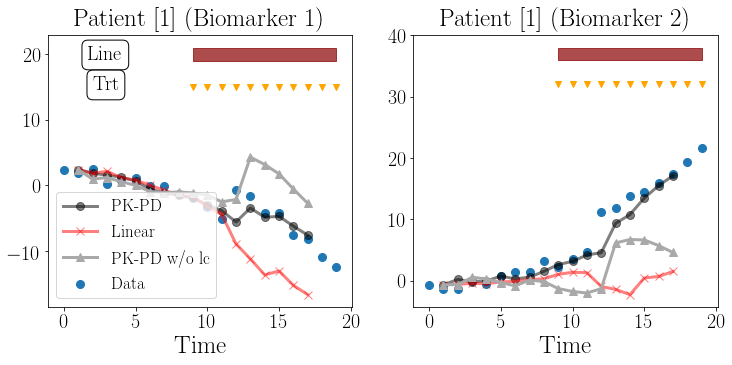

In [32]:
plt.rc('font', family='serif')
fig, axlist = plt.subplots(1,2,figsize=(12,5))
scolor=get_scolor()
fig.subplots_adjust(hspace = 0.4)

model_name  = 'PK-PD'
model_name2  = 'Linear'
model_name3  = 'PK-PD w/o lc'
tvt = 'valid'
pidx = 0
k2alph = {}
k2alph[0] = '(a)'
k2alph[1] = '(b)'
k2alph[2] = '(c)'
k2alph[3] = '(d)'
pt = 3
ks = [1]
axs = axlist.ravel()

for k, ax in enumerate([axs[0]]):    
    idx   = np.where(sorted_subtype==ks[k])[0]
    pred  = samples['syn_ssm_att_notexp'][idx[pt]]
    pred2 = samples['syn_ssm_lin'][idx[pt]]
    pred3 = samples['syn_ssm_att_nolc'][idx[pt]]
    
    data   = sorted_xs[idx[pt],:,:]
    trt_idx= np.where(sorted_as[idx[pt],:,1] == 1.)[0][0]
    xvals  = np.arange(data.shape[0])
    
    tlist_x = []; tlist_y = []
    treat_i = sorted_as[idx[pt],:,1]
    ymax = ax.get_ylim()[1]+0.05
    for t in range(treat_i.shape[0]):
        if treat_i[t] == 1:
            tlist_x.append(t)
            tlist_y.append(15)
    line1 = ax.scatter(tlist_x, tlist_y, marker='v', color='orange')
    line2 = ax.fill_between(tlist_x, np.array(tlist_y)+4, np.array(tlist_y)+6, color='darkred', alpha=0.7)
    
#     from matplotlib.legend import Legend
#     leg = Legend(ax, [line2,line1], ['line 1','trt 1'],
#                  loc='upper left', frameon=False, fontsize=15) #, bbox_to_anchor=(-.5,.99)
#     ax.add_artist(leg);
    
#     ax.annotate('Label', xy=(6, -6), xycoords='axes points',
#             size=14, ha='right', va='top',
#             bbox=dict(boxstyle='round', fc='w'))
    ax.annotate('Line', xy=(40, 247), xycoords='axes points',
            size=20, bbox=dict(boxstyle='round', fc='w'))
    ax.annotate('Trt', xy=(45, 217), xycoords='axes points',
            size=20, bbox=dict(boxstyle='round', fc='w'))

    
#     for bidx in range(2):
#     ax.plot(xvals, data[:,0],'--', color='navy', label = 'Data', linewidth=3.)
    ax.scatter(xvals, data[:,0], s = 64, label = 'Data')
#     ax.axvline(x=trt_idx, linestyle=':')
    ax.plot(xvals[1:18], pred[:,0],'o-', color='k', label = '%s'%(model_name), linewidth=3., alpha=0.5, markersize=8)
    ax.plot(xvals[1:18], pred2[:,0],'x-', color='r', label = '%s'%(model_name2), linewidth=3., alpha=0.5, markersize=8)
    ax.plot(xvals[1:18], pred3[:,0],'^-', color='darkgrey', label = '%s'%(model_name3), linewidth=3., markersize=8)
    tag = 'S[%d]'%(ks[k])
#     ax.set_title('%s Patient with subtype [%d]'%(k2alph[k], ks[k]), fontsize=20, pad=10)
    ax.set_title('Patient [%d] (Biomarker 1)'%(ks[k]), fontsize=25, pad=10)
    ax.set_xlabel('Time', fontsize=25)
    ax.tick_params(labelsize=20)
    if k == 0: 
#         ax.set_ylabel('S', fontsize=25)
        ax.legend(fontsize=17, loc=3)

# model_name = 'pk-pd (w/o lc)'
for k, ax in enumerate([axs[1]]): 
    idx   = np.where(sorted_subtype==ks[k])[0]
#     pred  = samples['dmm_aug_lin'][idx[pt]]
    pred  = samples['syn_ssm_att_notexp'][idx[pt]]
    pred2 = samples['syn_ssm_lin'][idx[pt]]
    pred3 = samples['syn_ssm_att_nolc'][idx[pt]]
    data  = sorted_xs[idx[pt],:,:]
    xvals = np.arange(data.shape[0])
    trt_idx= np.where(sorted_as[idx[pt],:,1] == 1.)[0][0]
    
    tlist_x = []; tlist_y = []
    treat_i = sorted_as[idx[pt],:,1]
#     ymax = ax.get_ylim()[1]+0.05
    for t in range(treat_i.shape[0]):
        if treat_i[t] == 1:
            tlist_x.append(t)
            tlist_y.append(32)
    ax.scatter(tlist_x, tlist_y, marker='v', color='orange')
    ax.fill_between(tlist_x, np.array(tlist_y)+4, np.array(tlist_y)+6, color='darkred', alpha=0.7)

    
#     for bidx in range(2):
    bidx = 2
#     ax.plot(xvals, data[:,1],'--', color='darkolivegreen', label = 'Data', linewidth=3.)
    ax.scatter(xvals, data[:,1], label = 'Data', s=64)
    ax.plot(xvals[1:18], pred[:,1],'o-', color='k', label = '%s'%(model_name), linewidth=3., alpha=0.5, markersize=8)
    ax.plot(xvals[1:18], pred2[:,1],'x-', color='r', label = '%s'%(model_name2), linewidth=3., alpha=0.5, markersize=8)
    ax.plot(xvals[1:18], pred3[:,1],'^-', color='darkgrey', label = '%s'%(model_name3), linewidth=3., markersize=8)
#     ax.axvline(x=trt_idx, linestyle=':')
#     ax.plot(xvals[1:18], pred[:,1],'o-', color='k', linewidth=3., alpha=0.5, markersize=8)
#     ax.plot(xvals[1:18], pred2[:,1],'x-', color='r', linewidth=3., alpha=0.5, markersize=8)
#     ax.plot(xvals[1:18], pred3[:,1],'^-', color='darkgrey', linewidth=3., markersize=8)
    tag = 'S[%d]'%(ks[k])
#     ax.set_title('%s Patient with subtype [%d]'%(k2alph[k+2], ks[k]), fontsize=20, pad=10)
#     ax.set_title('Patient [%d] (Linear)'%(ks[k]), fontsize=25, pad=10)
    ax.set_title('Patient [%d] (Biomarker %d)'%(ks[k],bidx), fontsize=25, pad=10)
    ax.set_xlabel('Time', fontsize=25)
    ax.tick_params(labelsize=20)
#     if k == 0: 
#         ax.legend(fontsize=15, loc=3)
    
plt.savefig('./plots/aaai-plots/ssm_syn_joint24_bigfonts_nolc_linetrt.pdf', bbox_inches='tight')

# MM Data

In [16]:
mname = {}; models = {}; fold = 1
mmdata = load_mmrf(fold_span = [fold], digitize_K = 20, digitize_method = 'uniform', suffix='_2mos')
# mname[f'ssm-lin-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold3_ssm_lin_epoch=08465-val_loss=80.52.ckpt'
# mname[f'ssm-att-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold3_ssm_att1epoch=13974-val_loss=53.37.ckpt'
mname[f'ssm-lin-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold1ssm_linepoch=14004-val_loss=74.14.ckpt'
# mname[f'ssm-att-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold1_ssm_att1epoch=13696-val_loss=57.20.ckpt'
mname[f'ssm-att-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold1_regFalse_ssm_att1epoch=13142-val_loss=63.89.ckpt'
## fold 0 
# if fold == 0: 
#     mname[f'ssm-lin-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold0_ssm_lin_epoch=14605-val_loss=88.48.ckpt'
#     mname[f'ssm-nl-fold{fold}']  = '../ief_core/tests/checkpoints/mmfold0_ssm_nl_epoch=07451-val_loss=83.10.ckpt'
#     mname[f'ssm-moe-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold0_ssm_moe_epoch=10475-val_loss=74.12.ckpt'
#     mname[f'ssm-att-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold0_ssm_att1epoch=14148-val_loss=65.06.ckpt'
# #     mname[f'ssm-att12-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold0_ssm_att1_att2epoch=14135-val_loss=64.56.ckpt'
# #     mname[f'ssm-baseline{fold}'] = '../ief_core/tests/checkpoints/mmfold0ssm_baselineepoch=14285-val_loss=99.59.ckpt'
# elif fold == 1:
# # #     ## fold 1 
#     mname[f'ssm-lin-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold1ssm_linepoch=14004-val_loss=74.14.ckpt'
#     mname[f'ssm-nl-fold{fold}']  = '../ief_core/tests/checkpoints/mmfold1_ssm_nl_epoch=07519-val_loss=76.88.ckpt'
#     mname[f'ssm-moe-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold1_ssm_moe_epoch=12673-val_loss=71.12.ckpt'
#     mname[f'ssm-att-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold1_ssm_att1epoch=13696-val_loss=57.20.ckpt'
# #     mname[f'ssm-att12-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold1_ssm_att1_att2epoch=13623-val_loss=59.14.ckpt'
#     mname[f'ssm-baseline{fold}'] = '../ief_core/tests/checkpoints/mmfold1ssm_baselineepoch=14997-val_loss=92.22.ckpt'
# elif fold == 2: 
# #     ## fold 2
#     mname[f'ssm-lin-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold2_ssm_lin_epoch=10805-val_loss=91.49.ckpt'
#     mname[f'ssm-nl-fold{fold}']  = '../ief_core/tests/checkpoints/mmfold2_ssm_nl_epoch=07478-val_loss=84.18.ckpt'
#     mname[f'ssm-moe-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold2_ssm_moe_epoch=14598-val_loss=77.14.ckpt'
#     mname[f'ssm-att-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold2_ssm_att1epoch=14798-val_loss=66.73.ckpt'
# #     mname[f'ssm-att12-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold2_ssm_att1_att2epoch=14606-val_loss=69.02.ckpt'
#     mname[f'ssm-baseline{fold}'] = '../ief_core/tests/checkpoints/mmfold2ssm_baselineepoch=12751-val_loss=97.99.ckpt'
if fold == 3:
#     ## fold 3 
    mname[f'ssm-lin-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold3_ssm_lin_epoch=08465-val_loss=80.52.ckpt'
    mname[f'ssm-nl-fold{fold}']  = '../ief_core/tests/checkpoints/mmfold3_ssm_nl_epoch=08438-val_loss=70.79.ckpt'
    mname[f'ssm-moe-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold3_ssm_moe_epoch=07993-val_loss=63.16.ckpt'
    mname[f'ssm-att-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold3_ssm_att1epoch=13974-val_loss=53.37.ckpt'
#     mname[f'ssm-att12-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold3_ssm_att1_att2epoch=11925-val_loss=55.52.ckpt'
#     mname[f'ssm-baseline{fold}'] = '../ief_core/tests/checkpoints/mmfold3ssm_baselineepoch=13696-val_loss=88.13.ckpt'
# elif fold == 4: 
# #     ## fold 4
#     mname[f'ssm-lin-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold4_ssm_lin_epoch=13385-val_loss=79.35.ckpt'
#     mname[f'ssm-nl-fold{fold}']  = '../ief_core/tests/checkpoints/mmfold4_ssm_nl_epoch=07690-val_loss=74.66.ckpt'
#     mname[f'ssm-moe-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold4_ssm_moe_epoch=08201-val_loss=66.47.ckpt'
#     mname[f'ssm-att-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold4_ssm_att1epoch=13337-val_loss=58.12.ckpt'
# #     mname[f'ssm-att12-fold{fold}'] = '../ief_core/tests/checkpoints/mmfold4_ssm_att1_att2epoch=13966-val_loss=57.53.ckpt'
#     mname[f'ssm-baseline{fold}'] = '../ief_core/tests/checkpoints/mmfold4ssm_baselineepoch=08013-val_loss=94.48.ckpt'

if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device  = torch.device('cpu')
print(mname.keys())
for model_n in mname.keys(): 
    checkpoint = torch.load(mname[model_n], map_location=lambda storage, loc: storage)
    hparams    = checkpoint['hyper_parameters']
    del hparams['trial']
    if 'baseline' in model_n: 
        trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
        model = SSMBaseline(trial, **hparams); model.setup(1)
        model.load_state_dict(checkpoint['state_dict'])
        models[model_n] = model
        models[model_n].to(device)
    elif 'ssm' in model_n and 'att12' not in model_n: 
        trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
        model = SSM(trial, **hparams); model.setup(1)
        model.load_state_dict(checkpoint['state_dict'])
        models[model_n] = model
        models[model_n].to(device)
    elif 'ssm' in model_n and 'att12' in model_n: 
        trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
        model = SSMAtt(trial, **hparams); model.setup(1)
        model.load_state_dict(checkpoint['state_dict'])
        models[model_n] = model
        models[model_n].to(device)

loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 35.81666666666667
20 19 20
dict_keys(['ssm-lin-fold1', 'ssm-att-fold1'])
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 35.81666666666667
20 19 20
using relu in inf. network
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 35.81666666666667
20 19 20
using relu in inf. network


## Pairwise Comparisons

In [19]:
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('test', device=device, att_mask=True)
(B, X, A, M, Y, CE, Am) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE, Am  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1], Am[lens>1]

nelbos = {}

# prepare list of things to compare (i.e. lotc)
# lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-nl-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-moe-fold{fold}')]
lotc = [(f'ssm-att-fold{fold}', f'ssm-baseline{fold}')]

for elem in lotc: 
    trials1 = []; trials2 = []
    nelboP = []; nelboB = []
    for t in range(20): 
        pkpd_n, base_n = elem
        nelbo_pkpd, _, _, _ = models[pkpd_n].get_loss(B, X, A, M, Y, CE, anneal=1.)
        nelbo_base, _, _, _ = models[base_n].get_loss(B, X, A, M, Y, CE, Am, anneal=1.)
        is_pkpd_better = (nelbo_base - nelbo_pkpd) > 0.
        trials1.append(np.mean(pt_numpy(is_pkpd_better))) 
        trials2.append(np.std(pt_numpy(is_pkpd_better)))
        nelboP.append(np.mean(pt_numpy(nelbo_pkpd)))
        nelboB.append(np.mean(pt_numpy(nelbo_base)))
    print(f'{pkpd_n} vs {base_n}: mean -- {np.mean(trials1)}, std -- {np.mean(trials2)}')
    print(f'{pkpd_n} nelbo: {np.mean(nelboP)}')
    print(f'{base_n} nelbo: {np.mean(nelboB)}')


using digitized y
ssm-att-fold3 vs ssm-baseline3: mean -- 0.9351063829787236, std -- 0.24504441835906238
ssm-att-fold3 nelbo: 64.85437774658203
ssm-baseline3 nelbo: 105.0400390625


In [16]:
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('test', device=device, att_mask=True)
(B, X, A, M, Y, CE, Am) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE, Am  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1], Am[lens>1]

nlls = {}

lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-nl-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-moe-fold{fold}'), (f'ssm-att-fold{fold}', f'ssm-baseline{fold}')]
# lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}')]

for comp in lotc: 
    att = comp[0]
    base = comp[1]
#     print(f'MODEL COMP {att} vs ')
    for model in [base, att]: 
        loss = models[model].imp_sampling(B, X, A, M, Y, CE, imp_samples = 25, idx = -1)
        mloss = pt_numpy(loss[0])
        nlls[model] = mloss

    thres = 10
    print(f'total examples: {len(nlls[att])}')
    num_pk_better  = np.sum(nlls[base] > (nlls[att] + thres))
    print(f'num examples where {att} does better: {num_pk_better}, {num_pk_better / len(nlls[att])}')
    num_lin_better = np.sum(nlls[att] > (nlls[base] + thres))
    print(f'num examples where {base} does better: {num_lin_better}, {num_lin_better / len(nlls[att])}')
    t1 = np.sum((nlls[base] > (nlls[att] - thres)) & (nlls[base] < (nlls[att] + thres)))
    print(f'num examples where it is unclear: {t1}, {t1 / len(nlls[att])}')
    print()
    print()
#option 1: put in the numbers 


using digitized y
total examples: 282
num examples where ssm-att-fold4 does better: 159, 0.5638297872340425
num examples where ssm-lin-fold4 does better: 4, 0.014184397163120567
num examples where it is unclear: 119, 0.4219858156028369


total examples: 282
num examples where ssm-att-fold4 does better: 136, 0.48226950354609927
num examples where ssm-nl-fold4 does better: 13, 0.04609929078014184
num examples where it is unclear: 133, 0.4716312056737589


total examples: 282
num examples where ssm-att-fold4 does better: 95, 0.33687943262411346
num examples where ssm-moe-fold4 does better: 7, 0.024822695035460994
num examples where it is unclear: 180, 0.6382978723404256


total examples: 282
num examples where ssm-att-fold4 does better: 272, 0.9645390070921985
num examples where ssm-baseline4 does better: 0, 0.0
num examples where it is unclear: 10, 0.03546099290780142




In [12]:
healthy_mins_max = {
    'cbc_abs_neut':(2., 7.5,1/3.), # abs neutrophil count (3.67, 1.), (2.83, 4.51)
    'chem_albumin':(34, 50,1/8.), # chemical albumin (43.62, 2.77), (41.30, 45.94)
    'chem_bun':(2.5, 7.1,1/5.), #BUN # reference range, (4.8, 1.15)
    'chem_calcium':(2.2, 2.7,2.), #Calcium, (2.45, 0.125)
    'chem_creatinine':(66, 112,1/36.), # creatinine, (83., 24.85), (62.22, 103.77)
    'chem_glucose':(3.9, 6.9,1/5.), # glucose, (4.91, 0.40), (4.58, 5.24)
    'cbc_hemoglobin':(13., 17.,1), # hemoglobin (12.90, 15.64), (8.86, 1.02)
    'chem_ldh':(2.33, 4.67,1/3.), #LDH, (3.5, 0.585)
    'serum_m_protein':(0.1, 1.1, 1), # M protein (<3 g/dL is MGUS, any presence of protein is pathological); am just using the data mean/std for this, (0.85, 1.89)
    'urine_24hr_m_protein':(0.0, 0.1, 1), # Urine M protein 
    'cbc_platelet':(150, 400,1/60.), # platelet count (206.42, 334.57), (270.5, 76.63)
    'chem_totprot':(6, 8,1/6.), # total protein, (7, 0.5)
    'urine_24hr_total_protein':(0, 0.23, 1), # 
    'cbc_wbc':(3, 10,1/4.), # WBC  (5.71, 8.44), (7.07, 1.63)
    'serum_iga':(0.85, 4.99, 1.), # IgA, (2.92, 1.035)
    'serum_igg':(6.10, 16.16,1/10.), # IgG, (11.13, 2.515)
    'serum_igm':(0.35, 2.42,1), #IgM, (1.385, 0.518)
    'serum_lambda':(0.57, 2.63, 1/2.), #serum lambda, (1.6, 0.515)
    'serum_kappa':(.33, 1.94,1/8.), #serum kappa , (1.135, 0.403)
    'serum_beta2_microglobulin':(0.7, 1.80, 1/3.), #serum_beta2_microglobulin,
    'serum_c_reactive_protein':(0.0, 1., 1.) #serum_c_reactive_protein,
}

scaled_healthy_min_max = {}
for k,v in healthy_mins_max.items(): 
    old_min, old_max, scale = v
    new_min = (old_min - old_max)*scale
    new_max = 0. 
    scaled_healthy_min_max[k] = (new_min, new_max)

using digitized y
average ISS stage of pkpd folks: 1.8677139282226562
average ISS stage of lin folks: 2.049919605255127
average ISS stage of unclear folks: 1.8205989599227905
average treatments for pkpd folks: tensor([[0.1000, 0.8540, 0.0511, 0.3285, 0.9197, 0.5401, 1.0000, 0.0000, 0.0000],
        [0.1978, 0.7153, 0.0584, 0.3796, 0.8613, 0.5109, 0.9854, 0.0073, 0.0000],
        [0.2869, 0.5328, 0.0511, 0.2409, 0.5839, 0.4015, 0.9489, 0.0146, 0.0000],
        [0.3672, 0.4453, 0.0292, 0.1752, 0.4745, 0.4526, 0.9051, 0.0292, 0.0000],
        [0.4511, 0.4453, 0.0438, 0.1387, 0.3869, 0.4745, 0.8832, 0.0438, 0.0000],
        [0.4847, 0.3285, 0.0584, 0.1095, 0.3723, 0.5328, 0.7883, 0.0657, 0.0073],
        [0.5562, 0.3285, 0.0730, 0.0876, 0.3723, 0.5620, 0.7664, 0.0803, 0.0073],
        [0.6350, 0.2847, 0.0730, 0.0803, 0.3431, 0.5547, 0.7591, 0.0803, 0.0146],
        [0.7080, 0.2774, 0.0730, 0.0730, 0.3285, 0.5401, 0.7445, 0.0876, 0.0146],
        [0.7657, 0.2555, 0.0803, 0.0584, 0.3066, 0.5

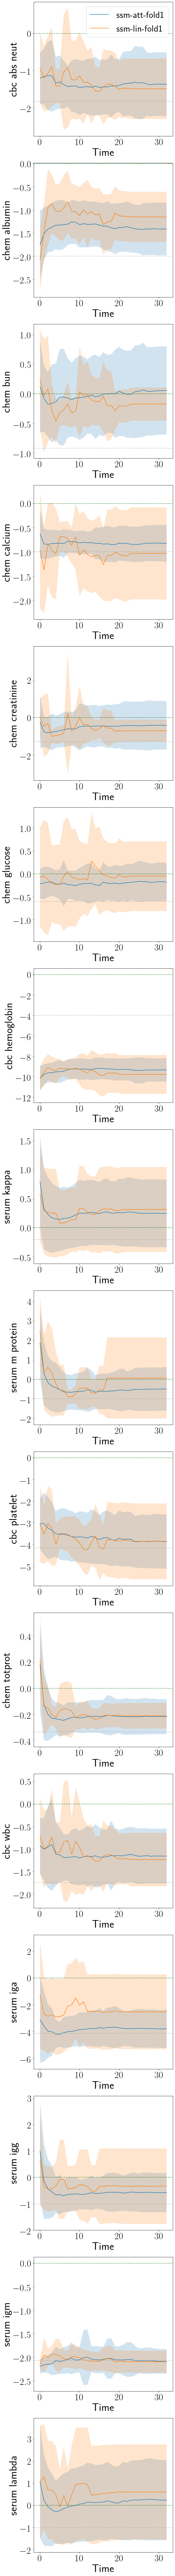

In [15]:
X_names_orig = mmdata[fold]['train']['feature_names_x']
X_names = mmdata[fold]['train']['feature_names_x']
A_names = mmdata[fold]['train']['feature_names_a']
B_names = mmdata[fold]['train']['feature_names']
all_names = np.concatenate([X_names, A_names, B_names],0)
print (all_names.shape, X_names.shape)
X_names = [s.replace('_', ' ') for s in X_names]
print(X_names)
print(A_names)
print(all_names)
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('test', device=device, att_mask=True)
(B, X, A, M, Y, CE, Am) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE, Am  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1], Am[lens>1]

nlls = {}

# lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-nl-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-moe-fold{fold}')]
lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}')]

for comp in lotc: 
    att = comp[0]
    base = comp[1]
    
    for model in [base, att]: 
        loss = models[model].imp_sampling(B, X, A, M, Y, CE, imp_samples = 25, idx = -1)
        mloss = pt_numpy(loss[0])
        nlls[model] = mloss
    thres = 10
    pkpd_idxs = np.where(nlls[base] > (nlls[att] + thres))[0]
    lin_idxs  = np.where(nlls[att] > (nlls[base] + thres))[0]
    unclear_idxs= np.where((nlls[base] > (nlls[att] - thres)) & (nlls[base] < (nlls[att] + thres)))[0]
    
    # visualize baseline 
    print(f'average ISS stage of pkpd folks: {torch.mean(B[pkpd_idxs,0])}')
    print(f'average ISS stage of lin folks: {torch.mean(B[lin_idxs,0])}')
    print(f'average ISS stage of unclear folks: {torch.mean(B[unclear_idxs,0])}')
    
    print(f'average treatments for pkpd folks: {torch.mean(A[pkpd_idxs],dim=0)}')
    print(f'average treatments for lin folks: {torch.mean(A[lin_idxs],dim=0)}')
    print(f'average treatments for unclear folks: {torch.mean(A[unclear_idxs],dim=0)}')
    fig, axlist = plt.subplots(len(X_names),1,figsize=(8,150))
    ax = axlist.ravel()
    j  = 0
    for i,name in enumerate(X_names): 
#         if 'kappa' not in name and 'lambda' not in name and 'bun' not in name: 
#             continue
        pkpd_x = pt_numpy(torch.mean(X[pkpd_idxs,:,i],dim=0))
        pkpd_std = pt_numpy(torch.std(X[pkpd_idxs,:,i],dim=0))
        lin_x  = pt_numpy(torch.mean(X[lin_idxs,:,i],dim=0))
        lin_std  = pt_numpy(torch.std(X[lin_idxs,:,i],dim=0))
        unclear_x  = pt_numpy(torch.mean(X[unclear_idxs,:,i],dim=0))
        vmin, vmax =scaled_healthy_min_max[X_names_orig[i]]
        ax[j].plot(np.arange(pkpd_x.shape[0]),pkpd_x, label=att)
        ax[j].fill_between(np.arange(pkpd_x.shape[0]),pkpd_x-pkpd_std,pkpd_x+pkpd_std,alpha=0.2)
        ax[j].plot(np.arange(lin_x.shape[0]),lin_x, label=base)
        ax[j].fill_between(np.arange(lin_x.shape[0]),lin_x-lin_std,lin_x+lin_std,alpha=0.2)
#         ax[j].plot(np.arange(unclear_x.shape[0]),unclear_x,label='unclear')
        ax[j].axhline(y=vmax, color='darkgreen', linestyle='--', alpha=0.6)
        ax[j].axhline(y=vmin, color='darkgrey', linestyle='--', alpha=0.6)
        ax[j].set_xlabel('Time', fontsize=35)
        ax[j].set_ylabel(f'{name}', fontsize=35)
        ax[j].tick_params(axis='x', labelsize=30)
        ax[j].tick_params(axis='y', labelsize=30)
        if j == 0: 
            ax[j].legend(fontsize=30)
        j += 1
    
#option 1: put in the numbers 


## Weights on $\alpha_1$ Linear Function

In [7]:
X_names_orig = mmdata[fold]['train']['feature_names_x']
X_names = mmdata[fold]['train']['feature_names_x']
A_names = mmdata[fold]['train']['feature_names_a']
B_names = mmdata[fold]['train']['feature_names']
all_names = np.concatenate([X_names, A_names, B_names],0)
print (all_names.shape, X_names.shape)
X_names = [s.replace('_', ' ') for s in X_names]
print(X_names)
print(A_names)
print(all_names)

(41,) (16,)
['cbc abs neut', 'chem albumin', 'chem bun', 'chem calcium', 'chem creatinine', 'chem glucose', 'cbc hemoglobin', 'serum kappa', 'serum m protein', 'cbc platelet', 'chem totprot', 'cbc wbc', 'serum iga', 'serum igg', 'serum igm', 'serum lambda']
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda' 'local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len'
 'line1' 'line2' 'line3plus' 'iss' 'age' 'gender' 'ecog'
 'serum_beta2_microglobulin' 'PC1' 'PC2' 'PC3' 'PC4' 'PC5' 'heavy_chain'
 'igg_type' 'iga_type' 'igm_type' 'kappa_type' 'lambda_type']


In [6]:
from sklearn.manifold import TSNE
from pyro.distributions import Normal, Independent, Categorical, LogNormal

class ModelIntrospector: 
    def __init__(self, model, data_loader, feat_names):
        self.model       = model 
        self.data_loader = data_loader
        self.X_names, self.A_names, self.B_names = feat_names

    def _stratify(self, stratify_params=None): 
        (B, X, A, M, Y, CE) = self.data_loader.dataset.tensors 
        if not stratify_params: 
            return (B, X, A, M, Y, CE)
        feat, val, keep_censored = stratify_params['feat'], stratify_params['val'], stratify_params['keep_censored']
        idx = np.where(self.B_names == feat)[0]
        if not keep_censored: 
            B = B[np.where(CEn==1)[0]]
            X = X[np.where(CEn==1)[0]]
            A = A[np.where(CEn==1)[0]]
            M = M[np.where(CEn==1)[0]]
            Y = Y[np.where(CEn==1)[0]]
            CE = CE[np.where(CEn==1)[0]]
        Bn  = pt_numpy(B)
        pt_idxs = np.where(Bn[:,idx] == val)[0]
        B, X, A, M, Y, CE   = B[pt_idxs], X[pt_idxs], A[pt_idxs], M[pt_idxs], Y[pt_idxs], CE[pt_idxs]
        return (B, X, A, M, Y, CE)

    def _get_con_signal(self, B, X, A, M, Y, CE, Tmax=None): 
        base_cat   = B[:,None,:].repeat(1, max(1, X.shape[1]-1), 1)
        _, _, lens = get_masks(M)
        B, X, A, M, Y, CE  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
        X0 = X[:,0,:]; A0  = A[:,0,:]

        # get alpha_1 
        if Tmax == None: 
            Tmax = X.shape[1]-1
        Aval = A[:,1:Tmax,:]
        con  = torch.cat([Aval[...,[0]],B[:,None,:].repeat(1,Aval.shape[1],1), Aval[...,1:]],-1)
        return con

    def _p_Zt(self, B, X, A, M, Y, CE, dist='posterior'): 
        base_cat   = B[:,None,:].repeat(1, max(1, X.shape[1]-1), 1)
        _, _, lens = get_masks(M)
        B, X, A, M, Y, CE  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
        X0 = X[:,0,:]; A0  = A[:,0,:]

        if dist == 'posterior': 
            Z_t, q_zt = self.model.inf_network(X, A, M, B)
        elif dist == 'prior': 
            Tmax     = X.shape[1]-1
            inp_cat  = torch.cat([B, X0, A0], -1)
            mu1      = self.model.prior_W(inp_cat)
            sig1     = torch.nn.functional.softplus(self.model.prior_sigma(inp_cat))
            Z_start  = torch.squeeze(Independent(Normal(mu1, sig1), 1).sample((1,)))
            meanlist = [mu1[:,None,:]]
            sigmalist= [sig1[:,None,:]]
            Zlist    = [Z_start]
            for t in range(1, Tmax):
                Ztm1       = Zlist[t-1]
                if self.model.hparams.include_baseline:
                    Aval = A[:,t-1,:]
                    Acat = torch.cat([Aval[...,[0]], B, Aval[...,1:]], -1)
                    mut, sigmat= self.model.transition_fxn(Ztm1, Acat)
                else:
                    mut, sigmat= self.transition_fxn(Ztm1, A[:,t-1,:])
                meanlist.append(mut[:,None,:])
                sigmalist.append(sigmat[:,None,:])
                Zlist.append(torch.squeeze(Independent(Normal(mut, sigmat), 1).sample((1,))))
            mu_prior, std_prior = torch.cat(meanlist, 1), torch.cat(sigmalist, 1)
            Z_t  = torch.cat([k[:,None,:] for k in Zlist],1)
        else: 
            raise ValueError('bad distribution type...')

        return Z_t[:,:-1,:]

    def get_ensemble_weights(self): 
        return torch.softmax(self.model.transition_fxn.t_mu.alphas, 1)

    def get_te_alpha1(self): 
        str_tensors = self._stratify()
        con = self._get_con_signal(*str_tensors)
        return self.model.transition_fxn.t_mu.treatment_exp.alpha_1_layer(con)

    def get_te_alpha1_weights(self): 
        return self.model.transition_fxn.t_mu.treatment_exp.alpha_1_layer.weight

    def jacobian_alpha1(self, stratify_params=None): 
        We = self.model.e_mu.weight 
        Wo = self.model.transition_fxn.t_mu.out_layer.weight 
        te_weight = self.get_ensemble_weights()[:,2]

        print('Emission weights shape....', We.shape)
        print('Output layer weights shape...', Wo.shape)
        print('Ensemble treatment effect function weights...', te_weight.shape)

        # compute jacobian
        str_tensors = self._stratify(stratify_params)
        con = self._get_con_signal(*str_tensors, Tmax=None)
        tvals = con[...,[0]]
        tmax_lot = ((tvals*con[...,-3:]).max(1, keepdims=True)[0]*con[...,-3:]).sum(-1, keepdims=True)
        pred     = self.model.transition_fxn.t_mu.treatment_exp.pred_prms(con[...,-3:])
        alpha_2, alpha_3, gamma = torch.sigmoid(pred[...,[0]]), torch.sigmoid(pred[...,[1]]), torch.sigmoid(pred[...,[2]])*tmax_lot
        mask     = (tvals-gamma)
        mask[mask<=0]= 0
        mask[mask>0] = 1
        res1 = (1-mask)*(1/(1+torch.exp(-alpha_2*(tvals-0.5*gamma))))
        res2 = mask*(1/((1+torch.exp(-alpha_3*0.5*gamma))*(1+torch.exp(alpha_3*(tvals-1.5*gamma)))))
        res  = res1+res2
        J    = torch.matmul(torch.matmul(res*te_weight[None,None,:], Wo.T), We.T) # should i have transposed?? 
        print('Jacobian shape...', (J.shape))

        return J 

    def jacobian_trt(self, trt, expect='posterior', stratify_params=None): 
        We = self.model.e_mu.weight 
        Wo = self.model.transition_fxn.t_mu.out_layer.weight 
        te_weight1 = self.get_ensemble_weights()[:,0]
        te_weight2 = self.get_ensemble_weights()[:,1]
        te_weight3 = self.get_ensemble_weights()[:,2]

        str_tensors = self._stratify(stratify_params)
        inpx = self._p_Zt(*str_tensors, expect)
        con  = self._get_con_signal(*str_tensors, Tmax=inpx.shape[1]+1)

        # term 1
        i1   = inpx*(1 - torch.tanh(self.model.transition_fxn.t_mu.control_layer(con))**2)
        Wlin = self.model.transition_fxn.t_mu.control_layer.weight[:,-(trt.shape[-1]):]
        t1   = torch.matmul(We, torch.matmul(Wo, torch.matmul(torch.diag_embed(i1*te_weight1[None,None,:]), Wlin)))

        # term 2 
        a    = con[...,1:]
        i2   = inpx*(1 - torch.tanh(self.model.transition_fxn.t_mu.logcell.controlfxn(a)))
        Wlc  = self.model.transition_fxn.t_mu.logcell.controlfxn.weight[:,-(trt.shape[-1]):]
        t2   = torch.matmul(We, torch.matmul(Wo, torch.matmul(torch.diag_embed(i2*te_weight2[None,None,:]), Wlc)))

        # term 3
        tvals = con[...,[0]]
        tmax_lot = ((tvals*con[...,-3:]).max(1, keepdims=True)[0]*con[...,-3:]).sum(-1, keepdims=True)
        pred     = self.model.transition_fxn.t_mu.treatment_exp.pred_prms(con[...,-3:])
        alpha_2, alpha_3, gamma = torch.sigmoid(pred[...,[0]]), torch.sigmoid(pred[...,[1]]), torch.sigmoid(pred[...,[2]])*tmax_lot
        mask     = (tvals-gamma)
        mask[mask<=0]= 0
        mask[mask>0] = 1
        res1 = (1-mask)*(1/(1+torch.exp(-alpha_2*(tvals-0.5*gamma))))
        res2 = mask*(1/((1+torch.exp(-alpha_3*0.5*gamma))*(1+torch.exp(alpha_3*(tvals-1.5*gamma)))))
        i3   = res1+res2
        Wte  = self.model.transition_fxn.t_mu.treatment_exp.alpha_1_layer.weight[...,-(trt.shape[-1]):]
        t3   = torch.matmul(We,torch.matmul(Wo,torch.matmul(torch.diag_embed(i3*te_weight3[None,None,:]), Wte)))

        # result (compute directional derivative)
        grad  = t1 + t2 + t3 
        return torch.matmul(grad, trt)

    def get_alpha1_tsne(self, bins, time=None, verbose=True): 
        alpha_1 = self.get_te_alpha1() 
        (B, X, A, M, Y, CE) = self.data_loader.dataset.tensors
        _, _, lens = get_masks(M)
        B, X, A, M, Y, CE  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]

        Yn = pt_numpy(Y); CEn = pt_numpy(CE)
        Yn_obs     = Yn[np.where(CEn==1)[0]]
        Yidx_obs   = np.where(Yn_obs==1)[1]
        binY       = np.digitize(Yidx_obs, bins)

        # print out information 
        if verbose: 
            print(f'time of death (observed+censored): {np.where(Yn==1)[1]}, {len(np.where(Yn==1)[0])}')
            print(f'time of death (observed): {Yidx_obs}, {len(Yidx_obs)}')
            print(f'binned Y: {binY}')
        ys = []
        for i in range(len(bins)): 
            y = np.where(binY == i)[0]
            ys.append(y)
            if verbose: 
                print(f'number of patients in group y{i+1}: {y.shape[0]}')

        result_CEs = []
        weights = models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()
        # run TSNEs for all t if no time range specified
        if time is None: 
            time = np.arange(alpha_1.shape[1])
        for t in time: 
            tsne = TSNE(n_components = 2)
#             idxs = np.where(np.mean(pt_numpy(weights[:,t,:]),dim=0)>0.7)[0]
            idxs = np.where(np.mean(pt_numpy(weights[:,t,:,-1]),axis=0)>0.5)[0]
            result = tsne.fit_transform(pt_numpy(alpha_1[:,t,idxs]))
            result_CE = result[np.where(CEn==1)[0]]
            result_CEs.append(result_CE)
        
        return result_CEs, ys
    
    def get_latent_tsne(self, bins, time=None, verbose=True): 
        (B, X, A, M, Y, CE) = self.data_loader.dataset.tensors
        _, _, lens = get_masks(M)
        B, X, A, M, Y, CE  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
        Zt = self._p_Zt(B, X, A, M, Y, CE, dist='posterior')
        
        Yn = pt_numpy(Y); CEn = pt_numpy(CE)
        Yn_obs     = Yn[np.where(CEn==1)[0]]
        Yidx_obs   = np.where(Yn_obs==1)[1]
        binY       = np.digitize(Yidx_obs, bins)

        # print out information 
        if verbose: 
            print(f'time of death (observed+censored): {np.where(Yn==1)[1]}, {len(np.where(Yn==1)[0])}')
            print(f'time of death (observed): {Yidx_obs}, {len(Yidx_obs)}')
            print(f'binned Y: {binY}')
        ys = []
        for i in range(len(bins)): 
            y = np.where(binY == i)[0]
            ys.append(y)
            if verbose: 
                print(f'number of patients in group y{i+1}: {y.shape[0]}')

        result_CEs = []
        # run TSNEs for all t if no time range specified
        if time is None: 
            time = np.arange(alpha_1.shape[1])
        for t in time: 
            tsne = TSNE(n_components = 2)
            result = tsne.fit_transform(pt_numpy(Zt[:,t,:]))
            result_CE = result[np.where(CEn==1)[0]]
            result_CEs.append(result_CE)
        
        return result_CEs, ys

using digitized y


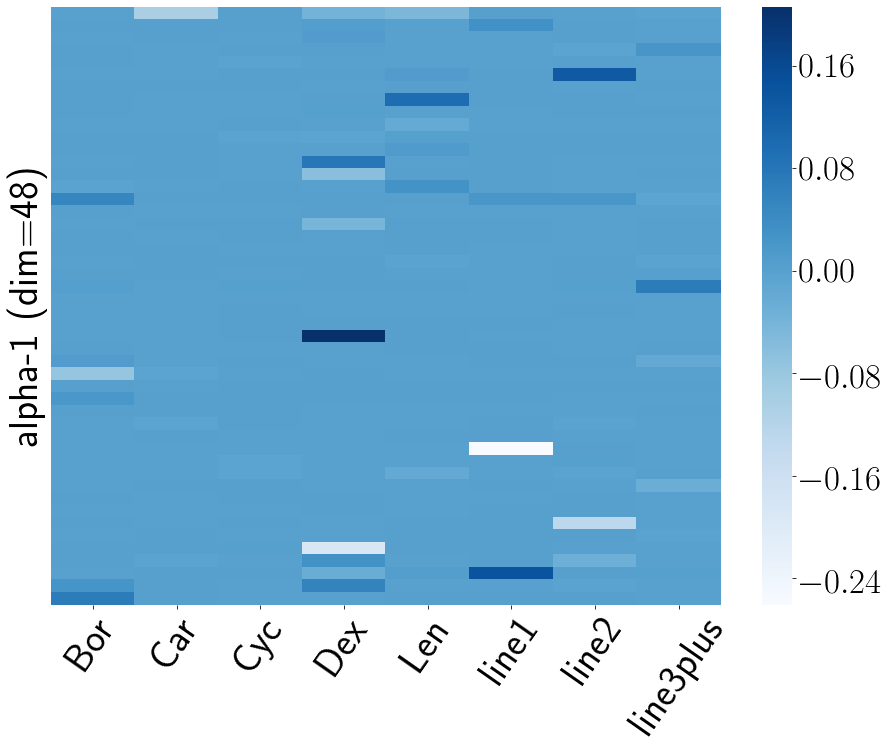

In [17]:
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('test', device=device)
EI = ModelIntrospector(models[f'ssm-att-fold{fold}'], data_loader, [X_names, A_names, B_names])
alpha_weights = EI.get_te_alpha1_weights()[:,-8:]
Anames_trt = A_names[1:]
fig, ax = plt.subplots(figsize=(15,11))
sns.heatmap(pt_numpy(alpha_weights), ax=ax, cmap='Blues', xticklabels=Anames_trt, yticklabels=False)
ax.set_ylabel('alpha-1 (dim=48)', fontsize=40)
ax.tick_params(axis='x', labelsize=40)
for item in ax.get_xticklabels():
    item.set_rotation(55)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=35)
plt.savefig('./plots/aaai-plots/ssm_alpha1_matrix.pdf',bbox_inches='tight')

## Attention Maps

In [17]:
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('test', device=device)
(B, X, A, M, Y, CE) = data_loader.dataset.tensors
_, _, lens         = get_masks(M)
B, X, A, M, Y, CE  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
m_t, m_g_t, _      = get_masks(M[:,1:,:])
Zt, q_zt          = models[f'ssm-att-fold{fold}'].inf_network(X, A, M, B)
Tmax               = Zt.shape[1]
X0 = X[:,0,:]; Xt = X[:,1:,:]
inp_cat  = torch.cat([B, X0, A[:,0,:]], -1)
# mu1      = self.prior_W(inp_cat)[:,None,:]
# sig1     = torch.nn.functional.softplus(self.prior_sigma(inp_cat))[:,None,:]
Zinp = Zt[:,:-1,:]; Aval = A[:,1:Tmax,:]
Acat = torch.cat([Aval[...,[0]],B[:,None,:].repeat(1,Aval.shape[1],1), Aval[...,1:]],-1)
inpx = Zinp; con = Acat
t_mu = models[f'ssm-att-fold{fold}'].transition_fxn.t_mu
#             mu2T, sig2T = self.transition_fxn(Zinp, Acat, eps = eps)
inp        = t_mu.inp_layer(inpx)
out_linear = inp*torch.tanh(t_mu.control_layer(con))
out_te     = t_mu.treatment_exp(inp, con)
out_logcell= t_mu.logcell(inp, con)
value = torch.cat((out_linear[...,None], out_te[...,None], out_logcell[...,None]), dim=-1).transpose(-2,-1)
key   = torch.cat((out_linear[...,None], out_te[...,None], out_logcell[...,None]), dim=-1).transpose(-2,-1)
query = inp[...,None,:]
t_mu.attn.dropout = None
_     = t_mu.attn(query, key, value, use_matmul=False)
#         out   = self.attn.forward(query, key, value, use_matmul=False).squeeze()
# p_x_mu, p_x_std    = self.p_X_Z(Z_t, A[:,1:Tmax+1,[0]])
# p_zt               = self.p_Zt_Ztm1(Z_t, A, B, X, A[:,0,:])
# print(models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[10:12].shape)
print(models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[:2].shape)
print(torch.mean(models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[:2],dim=1))

using digitized y
torch.Size([2, 31, 48, 3])
tensor([[[2.4476e-01, 1.2263e-01, 6.3261e-01],
         [4.9278e-01, 1.2984e-01, 3.7737e-01],
         [4.1251e-01, 2.1249e-01, 3.7500e-01],
         [4.4093e-01, 3.0431e-01, 2.5476e-01],
         [3.2708e-01, 2.9227e-01, 3.8065e-01],
         [5.1419e-01, 1.4746e-01, 3.3835e-01],
         [5.4751e-01, 1.1780e-01, 3.3470e-01],
         [3.3116e-01, 2.9849e-01, 3.7035e-01],
         [5.1363e-01, 1.1658e-01, 3.6978e-01],
         [3.1676e-01, 2.1605e-01, 4.6719e-01],
         [2.8406e-01, 3.6659e-01, 3.4935e-01],
         [5.5371e-01, 1.1399e-01, 3.3230e-01],
         [4.9882e-04, 9.9744e-01, 2.0647e-03],
         [4.8056e-01, 2.5523e-01, 2.6421e-01],
         [2.4957e-01, 3.5049e-01, 3.9994e-01],
         [3.5391e-01, 3.2224e-01, 3.2384e-01],
         [7.7476e-01, 3.7146e-02, 1.8810e-01],
         [5.8572e-01, 9.9209e-02, 3.1508e-01],
         [4.6395e-01, 2.6945e-01, 2.6661e-01],
         [2.7615e-01, 2.1397e-01, 5.0988e-01],
         [3.631

torch.Size([282, 31, 48, 3])
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
(48, 3)
[256 257 258 259 260 261 262 264 271 273 274 275 276 278 281]


Text(68.0, 0.5, 'State Space Dimension')

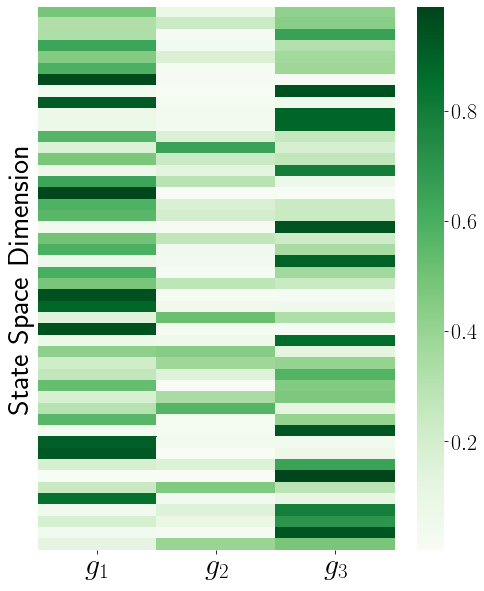

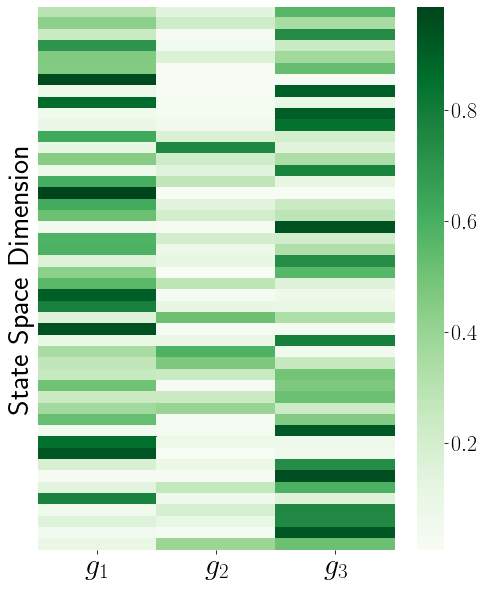

In [50]:
# print(models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[19].shape)
# print(torch.mean(models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[19],dim=0))
print(models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze().shape)
print(B_names)
# print(igg_idxs)
# print(iga_idxs)

temp1 = models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()
temp2 = models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()

weights  = torch.mean(torch.mean(temp1,dim=0)[:3],dim=0)
# weights  = torch.mean(models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[19],dim=0)
fig_dims = (8,10)
fig, ax  = plt.subplots(figsize=fig_dims)
print(pt_numpy(weights).shape)
ax.tick_params(labelsize=30)
ax2 = sns.heatmap(pt_numpy(weights), cmap="Greens", yticklabels=False, xticklabels=['$g_1$', '$g_2$', '$g_3$'], ax=ax)
# use matplotlib.colorbar.Colorbar object
cbar = ax2.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=22)

# plt.set_title('Weights on SSM-PK_PD model components (IgG Folks)',fontsize=30)
plt.ylabel('State Space Dimension', fontsize=30)
# plt.savefig('./plots/aaai-plots/ssm_pkpd_attmap_first10months.pdf',bbox_inches='tight')

# three-dimensional state; each dimension is a
print(np.unique(np.where(pt_numpy(M[:,29:30,:]))[0]))
weights  = torch.mean(torch.mean(temp2[np.unique(np.where(pt_numpy(M[:,22:24,:]))[0])],dim=0)[22:24],dim=0)
# weights  = torch.mean(torch.mean(temp2,dim=0)[15:18],dim=0)
# weights  = torch.mean(models[f'ssm-att-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[19],dim=0)
fig_dims = (8,10)
fig, ax  = plt.subplots(figsize=fig_dims)
ax.tick_params(labelsize=30)
ax2 = sns.heatmap(pt_numpy(weights), cmap="Greens", yticklabels=False, xticklabels=['$g_1$', '$g_2$', '$g_3$'], ax=ax)
# use matplotlib.colorbar.Colorbar object
cbar = ax2.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=22)

# plt.title('Weights on SSM-PK_PD model components (IgA Folks)',fontsize=30)
plt.ylabel('State Space Dimension', fontsize=30)
# plt.savefig('./plots/aaai-plots/ssm_pkpd_attmap_last10months_nonmissing.pdf',bbox_inches='tight')


In [ ]:
data, data_loader = models[f'ssm-att12-fold{fold}'].load_helper('valid', device=device, att_mask=True)
(B, X, A, M, Y, CE, Am) = data_loader.dataset.tensors
_, _, lens         = get_masks(M)
B, X, A, M, Y, CE, Am  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1], Am[lens>1]
m_t, m_g_t, _      = get_masks(M[:,1:,:])
Zt, q_zt          = models[f'ssm-att12-fold{fold}'].inf_network(X, A, M, B)
Tmax               = Zt.shape[1]
X0 = X[:,0,:]; Xt = X[:,1:,:]
inp_cat  = torch.cat([B, X0, A[:,0,:]], -1)
Zinp = Zt[:,:-1,:]; Aval = A[:,1:Tmax,:]
Acat = torch.cat([Aval[...,[0]],B[:,None,:].repeat(1,Aval.shape[1],1), Aval[...,1:]],-1)
Am_res = Am[:,1:Tmax,1:Tmax]
models[f'ssm-att12-fold{fold}'].attn.dropout = None
res  = models[f'ssm-att12-fold{fold}'].attn(models[f'ssm-att12-fold{fold}'].attn_lin(Zinp), Acat, Acat, mask=Am_res, use_matmul=True)
inpx = Zinp; con = res
t_mu = models[f'ssm-att12-fold{fold}'].transition_fxn.t_mu
inp        = t_mu.inp_layer(inpx)
out_linear = inp*torch.tanh(t_mu.control_layer(con))
out_te     = t_mu.treatment_exp(inp, con)
out_logcell= t_mu.logcell(inp, con)
value = torch.cat((out_linear[...,None], out_te[...,None], out_logcell[...,None]), dim=-1).transpose(-2,-1)
key   = torch.cat((out_linear[...,None], out_te[...,None], out_logcell[...,None]), dim=-1).transpose(-2,-1)
query = inp[...,None,:]
t_mu.attn.dropout = None
_     = t_mu.attn(query, key, value, use_matmul=False)
print(models[f'ssm-att12-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[:2].shape)
print(torch.mean(models[f'ssm-att12-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[:2],dim=1))

tensor([[0.1000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [0.2000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.7000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.9000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [1.1000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [1.2000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [1.3000,

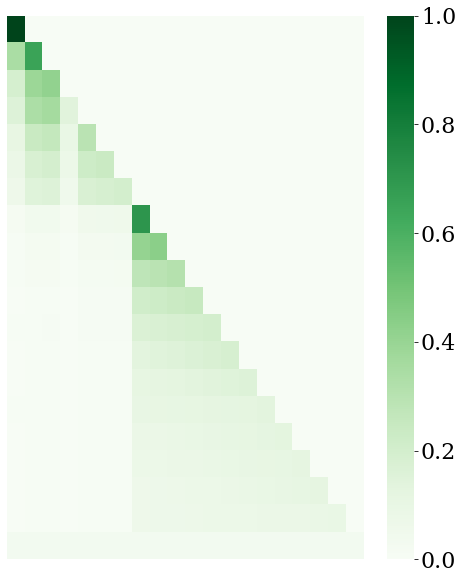

In [70]:
print(A[114])
weights0 = models[f'ssm-att12-fold{fold}'].attn.attn.squeeze()[114][:20,:20]
print(weights0.shape)
fig_dims = (8,10)
fig, ax  = plt.subplots(figsize=fig_dims)
print(pt_numpy(weights0).shape)
ax.tick_params(labelsize=30)
ax2 = sns.heatmap(pt_numpy(weights0), cmap="Greens", yticklabels=False, xticklabels=False, ax=ax)
# use matplotlib.colorbar.Colorbar object
cbar = ax2.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=22)

(48, 3)


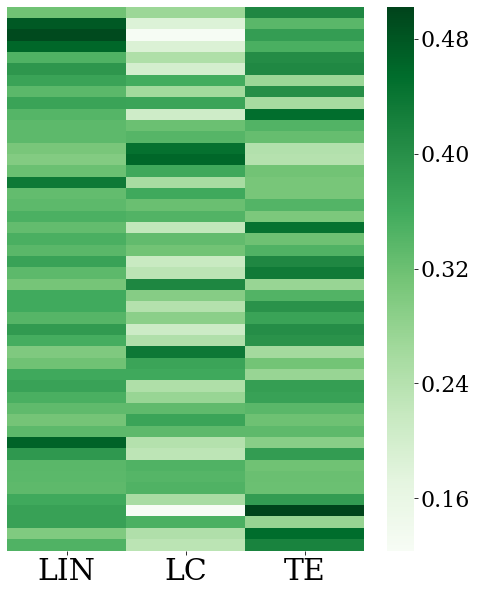

In [43]:
weights  = torch.mean(models[f'ssm-att12-fold{fold}'].transition_fxn.t_mu.attn.attn.squeeze()[23],dim=0)
fig_dims = (8,10)
fig, ax  = plt.subplots(figsize=fig_dims)
print(pt_numpy(weights).shape)
ax.tick_params(labelsize=30)
ax2 = sns.heatmap(pt_numpy(weights), cmap="Greens", yticklabels=False, xticklabels=['LIN', 'LC', 'TE'], ax=ax)
# use matplotlib.colorbar.Colorbar object
cbar = ax2.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=22)

In [28]:
data, data_loader = models[f'ssm-att-fold{fold}'].load_helper('valid', device=device)
(B, X, A, M, Y, CE) = data_loader.dataset.tensors
nlls = {}

column_names = ['NLL (imp. sampling estimate)', 'model']
df = pd.DataFrame(columns = column_names)

for model in [f'ssm-lin-fold{fold}', f'ssm-att-fold{fold}']: 
    loss = models[model].imp_sampling(B, X, A, M, Y, CE, imp_samples = 10, idx = -1)
    mloss = pt_numpy(loss[0])
    nlls[model] = mloss

for i in range(len(nlls[f'ssm-att-fold{fold}'])): 
    if nlls[f'ssm-att-fold{fold}'][i] > 200 or nlls[f'ssm-lin-fold{fold}'][i] > 200: continue
    df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [nlls[f'ssm-att-fold{fold}'][i], f'SSM PK-PD']
    df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [nlls[f'ssm-lin-fold{fold}'][i], f'SSM Linear']

using digitized y


(array([121, 142, 155]),)


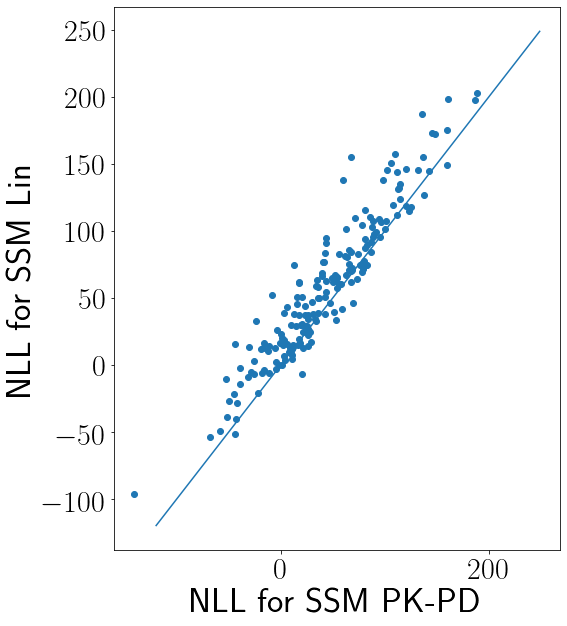

In [29]:
fig, ax = plt.subplots(figsize=(8,10))
print(np.where(nlls[f'ssm-att-fold{fold}']>200))
att = np.delete(nlls[f'ssm-att-fold{fold}'],np.where(nlls[f'ssm-att-fold{fold}']>200)[0])
lin = np.delete(nlls[f'ssm-lin-fold{fold}'],np.where(nlls[f'ssm-att-fold{fold}']>200)[0])
ax.scatter(att,lin)
ax.plot(np.arange(-120,250),np.arange(-120,250))
ax.set_xlabel('NLL for SSM PK-PD', fontsize=35)
ax.set_ylabel('NLL for SSM Lin', fontsize=35)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

No handles with labels found to put in legend.


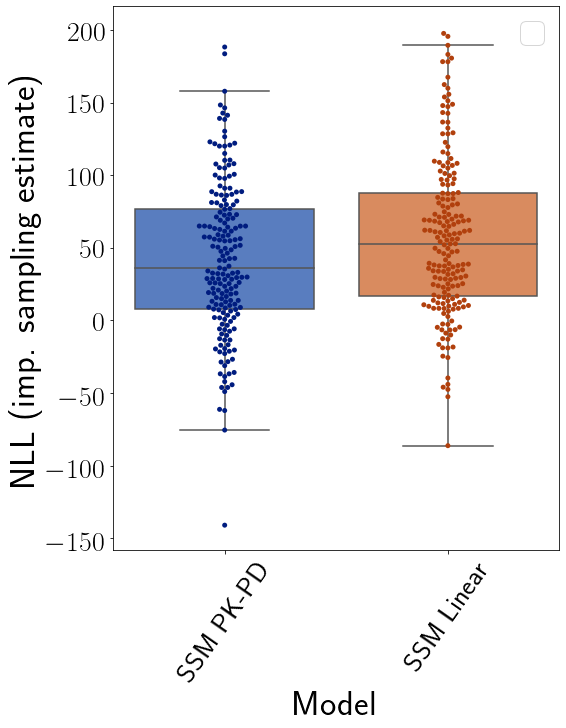

In [18]:
fig, ax = plt.subplots(figsize=(8,10))
a1 = sns.swarmplot(ax=ax, x='model', y='NLL (imp. sampling estimate)',
            data=df, palette='dark')
a1 = sns.boxplot(ax=ax, x='model', y='NLL (imp. sampling estimate)',
            data=df, palette='muted', showfliers=False)
# a1.set_ylim(-10,10)
a1.set_ylabel('NLL (imp. sampling estimate)', fontsize=35)
a1.set_xlabel('Model', fontsize=35)
a1.tick_params(axis='x', labelsize=28)
a1.tick_params(axis='y', labelsize=28)
a1.legend(fontsize=30)
for item in a1.get_xticklabels():
    item.set_rotation(55)

## NLL Plots

In [5]:
X_names = mmdata[fold]['train']['feature_names_x']
A_names = mmdata[fold]['train']['feature_names_a']
B_names = mmdata[fold]['train']['feature_names']
all_names = np.concatenate([X_names, A_names, B_names],0)
print (all_names.shape, X_names.shape)
X_names = [s.replace('_', ' ') for s in X_names]
print(X_names)
print(A_names)
print(all_names)

(41,) (16,)
['cbc abs neut', 'chem albumin', 'chem bun', 'chem calcium', 'chem creatinine', 'chem glucose', 'cbc hemoglobin', 'serum kappa', 'serum m protein', 'cbc platelet', 'chem totprot', 'cbc wbc', 'serum iga', 'serum igg', 'serum igm', 'serum lambda']
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda' 'local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len'
 'line1' 'line2' 'line3plus' 'iss' 'age' 'gender' 'ecog'
 'serum_beta2_microglobulin' 'PC1' 'PC2' 'PC3' 'PC4' 'PC5' 'heavy_chain'
 'igg_type' 'iga_type' 'igm_type' 'kappa_type' 'lambda_type']


In [14]:
def stratify_by_nll(B, X, A, M, Y, CE, thr=20.):
    thr = 20.
    model_loss = {}
    for model in models: 
        loss = models[model].get_loss(B, X, A, M, Y, CE)
        mloss = pt_numpy(loss[0])
        print(model)
        model_loss[model] = mloss 
    lin_loss = model_loss[f'ssm-lin-fold{fold}']; gated_loss = model_loss[f'ssm-att-fold{fold}']
    diff = (lin_loss - gated_loss)
    idxlist = np.where(diff >= thr)[0]
    # gated_sub = gated_loss[idxlist]

    return B[idxlist], X[idxlist], A[idxlist], M[idxlist], Y[idxlist], CE[idxlist]

def stratify_by_lens(B, X, A, M, Y, CE, slen=20): 
    _, _, lens = get_masks(M)
    return B[lens>slen], X[lens>slen], A[lens>slen], M[lens>slen], Y[lens>slen], CE[lens>slen]

def stratify_by_line(B, X, A, M, Y, CE): 
    # filter out patients who don't have second or third line therapies 
    idxs = np.unique(np.where(pt_numpy(A)[...,-2:] == 1.)[0])
    return B[idxs], X[idxs], A[idxs], M[idxs], Y[idxs], CE[idxs]

In [25]:
data, data_loader = models[f'ssm-att-fold{fold}'].load_helper('test', device=device)
(B, X, A, M, Y, CE) = data_loader.dataset.tensors
print(B.shape)
# look at examples that PK-PD models well 
# B, X, A, M, Y, CE = stratify_by_lens(B, X, A, M, Y, CE, slen=1)
T_forward  = 10; T_condition = 10
B, X, A, M, Y, CE = stratify_by_lens(B, X, A, M, Y, CE, slen=T_forward+T_condition)
# B, X, A, M, Y, CE = stratify_by_line(B, X, A, M, Y, CE)
print(B.shape)

using digitized y
torch.Size([301, 16])
torch.Size([108, 16])


In [35]:
column_names = ['NLL (imp. sampling estimate)', 'Biomarker', 'model']
df = pd.DataFrame(columns = column_names)

for idx, feat in enumerate(X_names):
    nlls = {}
    for model in [f'ssm-lin-fold{fold}', f'ssm-att-fold{fold}']: 
        loss = models[model].imp_sampling(B, X, A, M, Y, CE, imp_samples = 10, idx = idx)
        mloss = pt_numpy(loss[0])
        nlls[model] = mloss
    
    for i in range(len(nlls[f'ssm-att-fold{fold}'])): 
        df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [nlls[f'ssm-att-fold{fold}'][i], " ".join([f for f in feat.split("_")]), f'SSM PK-PD']
        df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [nlls[f'ssm-lin-fold{fold}'][i], " ".join([f for f in feat.split("_")]), f'SSM Linear']

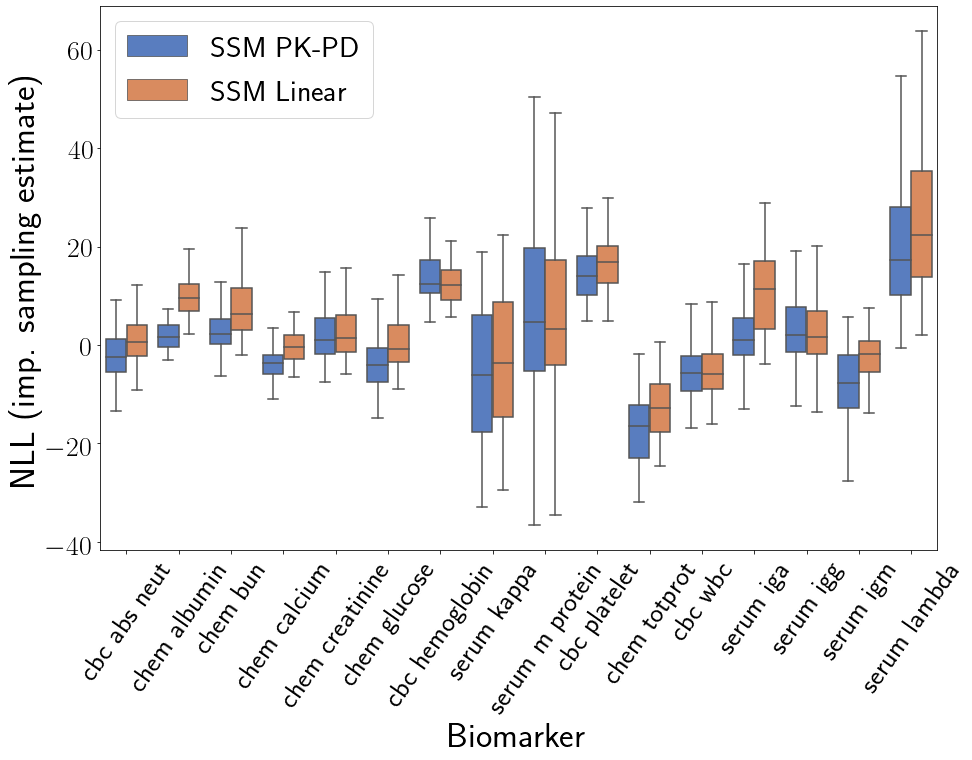

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
a1 = sns.boxplot(ax=ax, x='Biomarker', y='NLL (imp. sampling estimate)', hue='model',
            data=df, palette='muted', showfliers=False)
# a1.set_ylim(-10,10)
a1.set_ylabel('NLL (imp. sampling estimate)', fontsize=35)
a1.set_xlabel('Biomarker', fontsize=35)
a1.tick_params(axis='x', labelsize=28)
a1.tick_params(axis='y', labelsize=28)
a1.legend(fontsize=30)
for item in a1.get_xticklabels():
    item.set_rotation(55)
fig.savefig('./plots/aaai-plots/supp_fig2_bplot_nll_is.pdf',bbox_inches='tight')

## L1 Error Plots

In [36]:
## visualize conditional samples (what happens if you condition on some amount of time)
## try condition on 6 months, one year, two years 
pf_samples   = {}
cond_samples = {}
prior_samples= {}
print(B.shape)
T_condition  = 12; T_forward = 6
nelbo, pf_nelbo, p_z_mu, q_z_mu, inp_x_post, inp_x = models[f'ssm-att-fold{fold}'].inspect(T_forward, T_condition, B, X, A, M, Y, CE, nsamples=5)
_, pf_samples[f'ssm-att-fold{fold}'], _, _, cond_samples[f'ssm-att-fold{fold}'], prior_samples[f'ssm-att-fold{fold}'] = tuple([pt_numpy(k) for k in (nelbo, pf_nelbo, p_z_mu, q_z_mu, inp_x_post, inp_x)])
nelbo, pf_nelbo, p_z_mu, q_z_mu, inp_x_post, inp_x = models[f'ssm-lin-fold{fold}'].inspect(T_forward, T_condition, B, X, A, M, Y, CE, nsamples=5)
_, pf_samples[f'ssm-lin-fold{fold}'], _, _, cond_samples[f'ssm-lin-fold{fold}'], prior_samples[f'ssm-lin-fold{fold}'] = tuple([pt_numpy(k) for k in (nelbo, pf_nelbo, p_z_mu, q_z_mu, inp_x_post, inp_x)]) 

data_cond= pt_numpy(X[:,:T_condition+T_forward,:])
obs_cond = pt_numpy(M[:,:T_condition+T_forward,:])
a_cond   = pt_numpy(A[:,:T_condition+T_forward,:])
# data_cond[obs_cond==0] = np.nan

data_prior= pt_numpy(X[:,:T_forward,:])
obs_prior = pt_numpy(M[:,:T_forward,:])
a_prior   = pt_numpy(A[:,:T_forward,:])
print(data_prior[:,0,:].shape)
print(prior_samples[f'ssm-att-fold{fold}'][:,0,:].shape)
assert data_prior[:,0,:].shape == prior_samples[f'ssm-att-fold{fold}'][:,0,:].shape
# data_prior[obs_prior==0] = np.nan

torch.Size([108, 16])
(108, 16)
(108, 16)


[[2.6129832  2.9050546  1.358151   ... 4.793568   0.74349666 5.5494223 ]
 [1.0830321  1.2743521  0.         ... 1.5407754  0.14871407 0.49993235]
 [1.6369877  0.8429507  1.0601397  ... 0.24439815 0.9600973  0.4925186 ]
 ...
 [1.5315076  0.7416806  0.33616722 ... 0.85742855 0.6963444  2.14878   ]
 [2.323261   1.4459578  1.9374741  ... 2.5842075  0.84212375 1.589463  ]
 [3.336981   2.7417798  1.2141925  ... 0.3409183  1.0070492  0.64541084]]
[[0.89186144 2.16572    1.7174133  ... 5.405734   1.2276742  6.424527  ]
 [0.36920476 1.5732508  0.         ... 1.9893559  0.42907524 0.54307103]
 [1.9393432  0.67421293 0.99238956 ... 0.2525993  1.5408006  0.6445468 ]
 ...
 [1.3048017  0.83483636 0.32742488 ... 0.3175815  0.43585992 3.6280036 ]
 [1.802235   1.5608763  2.438243   ... 2.144183   0.784865   1.4775226 ]
 [3.8013415  1.2902765  1.1568949  ... 1.4180603  1.2823864  0.237064  ]]


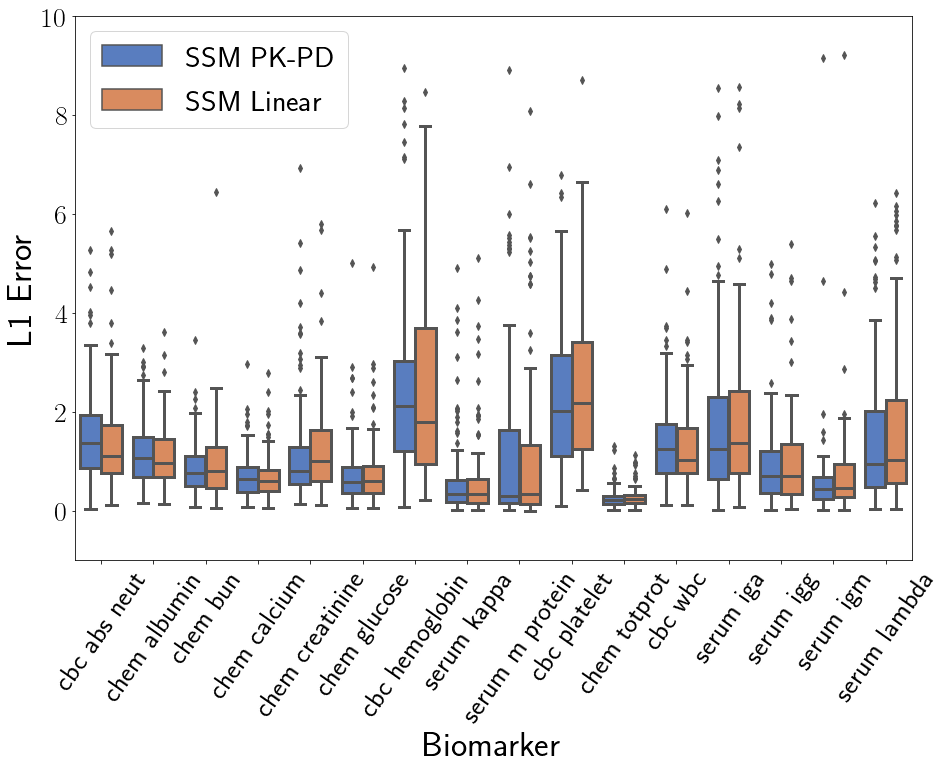

In [38]:
column_names = ['MSE', 'Biomarker', 'model']
df = pd.DataFrame(columns = column_names)

setup   = 'cond'
if setup == 'forward': 
    samples = prior_samples 
elif setup == 'cond': 
    samples = cond_samples

# model_dict = {'fomm_gated': 'FOMM PK-PD', 'fomm_linear': 'FOMM Linear', 'fomm_nl': 'FOMM NL', 'fomm_moe': 'FOMM MOE'}
model_dict = {f'ssm-att-fold{fold}': 'SSM PK-PD', f'ssm-lin-fold{fold}': 'SSM Linear', 'nl-lin': 'SSM NL', 'moe-lin': 'SSM MOE'}

for model in [f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}']:
    if model == 'nl-lin' or model == 'moe-lin':
        continue
    
    if setup == 'forward':
        Xv     = pt_numpy(X[:,1:T_forward])
        Mv     = pt_numpy(M[:,1:T_forward])
        pred   = samples[model][:,1:]
    elif setup == 'cond':
        Xv = pt_numpy(X[:,T_condition:T_condition+T_forward])
        Mv = pt_numpy(M[:,T_condition:T_condition+T_forward])
        pred = samples[model][:,-T_forward:]
    diff_t = ((np.abs(pred-Xv))*Mv)
    diff   = diff_t.sum(1); m = Mv.sum(1)
    print(diff)
    for feat, feat_name in enumerate(X_names): 
        mse_total = diff[:,feat]
        mse_true  = mse_total[np.where(m[:,feat] != 0.)[0]]
        for i in range(len(mse_true)): 
            df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [mse_true[i], " ".join([f for f in feat_name.split("_")]), f'{model_dict[model]}']

fig, ax = plt.subplots(figsize=(15,10))
a1 = sns.boxplot(ax=ax, x='Biomarker', y='MSE', hue='model',
            data=df, palette='muted', linewidth=3)
a1.set_ylim(-1,10)
a1.set_ylabel('L1 Error', fontsize=35)
a1.set_xlabel('Biomarker', fontsize=35)
a1.tick_params(axis='x', labelsize=28)
a1.tick_params(axis='y', labelsize=28)
a1.legend(fontsize=30, loc='upper left')
for item in a1.get_xticklabels():
    item.set_rotation(55)
fig.savefig('./plots/aaai-plots/supp_fig2_bplot_cond2y_f6m.pdf',bbox_inches='tight')

## Forward Samples

In [6]:
healthy_mins_max = {
    'cbc_abs_neut':(2., 7.5,1/3.), # abs neutrophil count (3.67, 1.), (2.83, 4.51)
    'chem_albumin':(34, 50,1/8.), # chemical albumin (43.62, 2.77), (41.30, 45.94)
    'chem_bun':(2.5, 7.1,1/5.), #BUN # reference range, (4.8, 1.15)
    'chem_calcium':(2.2, 2.7,2.), #Calcium, (2.45, 0.125)
    'chem_creatinine':(66, 112,1/36.), # creatinine, (83., 24.85), (62.22, 103.77)
    'chem_glucose':(3.9, 6.9,1/5.), # glucose, (4.91, 0.40), (4.58, 5.24)
    'cbc_hemoglobin':(13., 17.,1), # hemoglobin (12.90, 15.64), (8.86, 1.02)
    'chem_ldh':(2.33, 4.67,1/3.), #LDH, (3.5, 0.585)
    'serum_m_protein':(0.1, 1.1, 1), # M protein (<3 g/dL is MGUS, any presence of protein is pathological); am just using the data mean/std for this, (0.85, 1.89)
    'urine_24hr_m_protein':(0.0, 0.1, 1), # Urine M protein 
    'cbc_platelet':(150, 400,1/60.), # platelet count (206.42, 334.57), (270.5, 76.63)
    'chem_totprot':(6, 8,1/6.), # total protein, (7, 0.5)
    'urine_24hr_total_protein':(0, 0.23, 1), # 
    'cbc_wbc':(3, 10,1/4.), # WBC  (5.71, 8.44), (7.07, 1.63)
    'serum_iga':(0.85, 4.99, 1.), # IgA, (2.92, 1.035)
    'serum_igg':(6.10, 16.16,1/10.), # IgG, (11.13, 2.515)
    'serum_igm':(0.35, 2.42,1), #IgM, (1.385, 0.518)
    'serum_lambda':(0.57, 2.63, 1/2.), #serum lambda, (1.6, 0.515)
    'serum_kappa':(.33, 1.94,1/8.), #serum kappa , (1.135, 0.403)
    'serum_beta2_microglobulin':(0.7, 1.80, 1/3.), #serum_beta2_microglobulin,
    'serum_c_reactive_protein':(0.0, 1., 1.) #serum_c_reactive_protein,
}

scaled_healthy_min_max = {}
for k,v in healthy_mins_max.items(): 
    old_min, old_max, scale = v
    new_min = (old_min - old_max)*scale
    new_max = 0. 
    scaled_healthy_min_max[k] = (new_min, new_max)

In [7]:
def stratify_by_nll(B, X, A, M, Y, CE, thr=20.):
#     thr = 20.
    model_loss = {}
    for model in models: 
        loss = models[model].get_loss(B, X, A, M, Y, CE)
        mloss = pt_numpy(loss[0])
        print(model)
        model_loss[model] = mloss 
    lin_loss = model_loss[f'ssm-lin-fold{fold}']; gated_loss = model_loss[f'ssm-att-fold{fold}']
    diff = (lin_loss - gated_loss)
    idxlist = np.where(diff >= thr)[0]
    # gated_sub = gated_loss[idxlist]

    return B[idxlist], X[idxlist], A[idxlist], M[idxlist], Y[idxlist], CE[idxlist]

def stratify_by_lens(B, X, A, M, Y, CE, slen=20): 
    _, _, lens = get_masks(M)
    return B[lens>slen], X[lens>slen], A[lens>slen], M[lens>slen], Y[lens>slen], CE[lens>slen]

def stratify_by_line(B, X, A, M, Y, CE): 
    # filter out patients who don't have second or third line therapies 
    idxs = np.unique(np.where(pt_numpy(A)[...,-2:] == 1.)[0])
    return B[idxs], X[idxs], A[idxs], M[idxs], Y[idxs], CE[idxs]

In [10]:
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('valid', device=device)
(B, X, A, M, Y, CE) = data_loader.dataset.tensors

T_forward  = 10; T_condition = 10
B, X, A, M, Y, CE = stratify_by_nll(B, X, A, M, Y, CE, thr=20.)
B, X, A, M, Y, CE = stratify_by_lens(B, X, A, M, Y, CE, slen=T_forward+T_condition)
# B, X, A, M, Y, CE = stratify_by_line(B, X, A, M, Y, CE)
print(B.shape)

pf_samples   = {}
cond_samples = {}
prior_samples= {}
nelbo, pf_nelbo, p_z_mu, q_z_mu, inp_x_post, inp_x = models[f'ssm-att-fold{fold}'].inspect(T_forward, T_condition, B, X, A, M, Y, CE, nsamples=3, eps=0.)
_, pf_samples[f'ssm-att-fold{fold}'], _, _, cond_samples[f'ssm-att-fold{fold}'], prior_samples[f'ssm-att-fold{fold}'] = tuple([pt_numpy(k) for k in (nelbo, pf_nelbo, p_z_mu, q_z_mu, inp_x_post, inp_x)])
nelbo, pf_nelbo, p_z_mu, q_z_mu, inp_x_post, inp_x = models[f'ssm-lin-fold{fold}'].inspect(T_forward, T_condition, B, X, A, M, Y, CE, nsamples=3, eps=0.)
_, pf_samples[f'ssm-lin-fold{fold}'], _, _, cond_samples[f'ssm-lin-fold{fold}'], prior_samples[f'ssm-lin-fold{fold}'] = tuple([pt_numpy(k) for k in (nelbo, pf_nelbo, p_z_mu, q_z_mu, inp_x_post, inp_x)])

data_cond= pt_numpy(X[:,:T_condition+T_forward,:])
obs_cond = pt_numpy(M[:,:T_condition+T_forward,:])
a_cond   = pt_numpy(A[:,:T_condition+T_forward,:])
data_cond[obs_cond==0] = np.nan

data_prior= pt_numpy(X[:,:T_forward,:])
obs_prior = pt_numpy(M[:,:T_forward,:])
a_prior   = pt_numpy(A[:,:T_forward,:])
# print(data_prior[:,0,:].shape)
# print(prior_samples[0.][:,0,:].shape)
# assert data_prior[:,0,:].shape == prior_samples[0.][:,0,:].shape
data_prior[obs_prior==0] = np.nan

using digitized y
ssm-lin-fold3
ssm-nl-fold3
ssm-moe-fold3
ssm-att-fold3
torch.Size([46, 16])


In [11]:
X_names_orig = mmdata[fold]['train']['feature_names_x']
A_names = mmdata[fold]['train']['feature_names_a']
B_names = mmdata[fold]['train']['feature_names']
all_names = np.concatenate([X_names_orig, A_names, B_names],0)
print (all_names.shape, X_names_orig.shape)
X_names = [s.replace('_', ' ') for s in X_names_orig]
print(B_names)
print(X_names)
print(A_names)
print(all_names)

(41,) (16,)
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
['cbc abs neut', 'chem albumin', 'chem bun', 'chem calcium', 'chem creatinine', 'chem glucose', 'cbc hemoglobin', 'serum kappa', 'serum m protein', 'cbc platelet', 'chem totprot', 'cbc wbc', 'serum iga', 'serum igg', 'serum igm', 'serum lambda']
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda' 'local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len'
 'line1' 'line2' 'line3plus' 'iss' 'age' 'gender' 'ecog'
 'serum_beta2_microglobulin' 'PC1' 'PC2' 'PC3' 'PC4' 'PC5' 'heavy_chain'
 'igg_type' 'iga_type' 'igm_type' 'kappa_

In [109]:
    
def plot_features_alt(plotlist, data, treat, X_names, A_names, group = 'serum', nplots = 3, xpush=1,ypush=1):
    assert group in ['serum','cbc'],'bad group'
    if group == 'cbc':
        if nplots == 1:
            fig, axgrid = plt.subplots(nplots,5,figsize=(20,5))
            axgrid = axgrid.reshape(1, 5)
        else:
            fig, axgrid = plt.subplots(nplots,5,figsize=(20,10))
        group_idx   = [3, 4, 6, 9, 7]
    elif group == 'serum':
        if nplots == 1:
            fig, axgrid = plt.subplots(nplots,2,figsize=(9,5.5))
            axgrid = axgrid.reshape(1, 2)
        else:
            fig, axgrid = plt.subplots(nplots,5,figsize=(20,10))
#         group_idx   = [12, 13, 14, 15, 7]
        group_idx   = [13,15]
    else:
        raise ValueError('bad setting for group')
    formatting = {}
    formatting[0] = ('--x','r')
    formatting[1] = ('--o','k')
    formatting[2] = ('--v','g')
    formatting[3] = ('--^','b')
    formatting[4] = ('--.','m')
    
    A_markers  = {}
    A_markers['Bor'] = '>'
    A_markers['Car'] = '<'
    A_markers['Cyc'] = '^'
    A_markers['Len'] = 'v'
    A_markers['Dex'] = 'o'
    axlist = axgrid.ravel()

    from matplotlib.legend import Legend
    lines = []; labels = []
    
    for j, ax in enumerate(axlist): 
        ctr= group_idx[j]
        x  = np.arange(data.shape[1])
        ax.scatter(x, data[0][:,ctr].astype('float'), s=64, label='Data')
        for pltidx, (name, vals) in enumerate(plotlist):
            # x = np.arange(vals.shape[1]) 
            ax.plot(x, vals[0][:,ctr], formatting[pltidx][0], label=name, color=formatting[pltidx][1], alpha = 0.5, markersize=8)
#         if i==0:
        ax.set_title(X_names[ctr], fontsize=25)
        vmin, vmax = scaled_healthy_min_max[X_names_orig[ctr]]
        ax.axhline(y=vmax, color='darkgreen', linestyle='--', alpha=0.6)
        ax.axhline(y=vmin, color='darkgrey', linestyle='--', alpha=0.6)
        ax.xaxis.set_ticks(np.arange(0, data.shape[1], 2))


        ymax = ax.get_ylim()[1]+0.05
        # Plot treatments
#         import pdb; pdb.set_trace()
        treat_i = treat[0]
        for tidx in range(treat_i.shape[1]-1):
            if A_names[tidx]=='local_clock' or 'line' in A_names[tidx]:
                continue
            tlist_x = []
            tlist_y = []
            for t in range(treat_i.shape[0]):
                if treat_i[t, tidx] ==1:
                    tlist_x.append(t)
                    tlist_y.append(ymax+0.34*tidx)
            l = ax.scatter(tlist_x, tlist_y, marker=A_markers[A_names[tidx]])
            if j == 1:
                lines.append(l); labels.append(A_names[tidx])
        
        lot1list_x = []; lot1list_y = []
        lot2list_x = []; lot2list_y = []
        lot3list_x = []; lot3list_y = []
        for t in range(treat_i.shape[0]): 
            line = np.where(treat_i[t][-3:] == 1.)[0]+1
            if line == 1: 
                lot1list_x.append(t); lot1list_y.append(ymax+0.1*treat_i.shape[1]-1)
            elif line == 2: 
                lot2list_x.append(t); lot2list_y.append(ymax+0.1*treat_i.shape[1]-1)
            elif line == 3: 
                lot3list_x.append(t); lot3list_y.append(ymax+0.1*treat_i.shape[1]-1)
#                     ax.fill_between(tlist_x, np.array(tlist_y)+4, np.array(tlist_y)+6, color='darkred', alpha=0.7)
        if j == 1: 
            if len(lot3list_x) != 0: 
                l = ax.fill_between(lot3list_x, np.array(lot3list_y)+.7,np.array(lot3list_y)+1., color='darkgreen', alpha=0.7)
                lines.insert(0,l); labels.insert(0,'Line 3')
            if len(lot2list_x) != 0: 
                l = ax.fill_between(lot2list_x, np.array(lot2list_y)+.7,np.array(lot2list_y)+1., color='darkblue', alpha=0.7)
                lines.insert(0,l); labels.insert(0,'Line 2')
            if len(lot1list_x) != 0: 
                l = ax.fill_between(lot1list_x, np.array(lot1list_y)+.7,np.array(lot1list_y)+1., color='darkred', alpha=0.7)
                lines.insert(0,l); labels.insert(0,'Line 1')

        ylims = ax.get_ylim()
        if j==0:
            ax.legend(loc='best',bbox_to_anchor=(-.3,.3),
                      fancybox=True, shadow=True, ncol=1, fontsize = 25)
        if j==0 or j == 1: 
            ax.set_xlabel('Time (per 2 months)', fontsize=25)
        
    leg = Legend(axlist[0], lines, labels,
                 loc='best', frameon=True, fancybox = True, shadow=True, fontsize=25, bbox_to_anchor=(-.33,1.09))
    axlist[0].add_artist(leg);
    
    plt.subplots_adjust(top=0.9, wspace=0.25)
#     plt.xlabel('Time (per 2 months)', fontsize=25)
    return fig

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:75: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:77: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/ipykernel_launcher.py:79: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


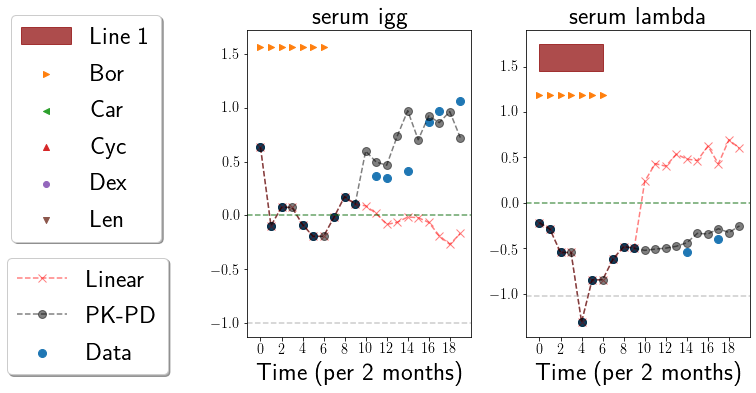

In [111]:
nplots = 1
setup  = 'cond'
idx    = 5
idxlist = np.arange(prior_samples[f'ssm-att-fold{fold}'].shape[0])+idx

if setup == 'forward':
    l = [('Linear', prior_samples[f'ssm-lin-fold{fold}'][idx:])]
    l += [(f'PK-PD', prior_samples[f'ssm-att-fold{fold}'][idx:])]
    fig = plot_features_alt(l, data_prior[idx:], a_prior[idx:], X_names, A_names, group='serum', nplots = nplots, xpush=6.9, ypush=2)
    fig = plot_features_alt(l, data_prior[idx:], a_prior[idx:], X_names, A_names, group='cbc', nplots = nplots, xpush=6.9, ypush=2)
else:
    l = [('Linear', cond_samples[f'ssm-lin-fold{fold}'][idx:])]
    l += [(f'PK-PD', cond_samples[f'ssm-att-fold{fold}'][idx:])]
    fig = plot_features_alt(l, data_cond[idx:], a_cond[idx:], X_names, A_names, group='serum', nplots = nplots, xpush=8)
#     fig = plot_features_alt(l, data_cond[idx:], a_cond[idx:], X_names, A_names, group='cbc', nplots = nplots, xpush=8)
# fig.suptitle('Lab for T = %d conditioned on patient %s baseline data'%(T_forward, ','.join([str(k) for k in idxlist[:nplots]])), fontsize=20)
# fig.suptitle('Lab for T = %d conditioned on patient baseline data'%(T_forward), fontsize=20)
fig.savefig('./plots/aaai-plots/fold3_idx5_main_cond10_forw10_2markers.pdf',bbox_inches='tight')

In [ ]:
'''
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('valid', device=device)
(B, X, A, M, Y, CE) = data_loader.dataset.tensors

T_forward  =7; T_condition = 7
# B, X, A, M, Y, CE = stratify_by_nll(B, X, A, M, Y, CE, thr=20.)
B, X, A, M, Y, CE = stratify_by_lens(B, X, A, M, Y, CE, slen=T_forward+T_condition)
B, X, A, M, Y, CE = stratify_by_line(B, X, A, M, Y, CE)
print(B.shape)

trt_samples = {}
trt_samples[f'ssm-att-fold{fold}'] = pt_numpy(models[f'ssm-att-fold{fold}'].inspect_trt(B, X, A, M, Y, CE, nsamples=3))
trt_samples[f'ssm-lin-fold{fold}']   = pt_numpy(models[f'ssm-lin-fold{fold}'].inspect_trt(B, X, A, M, Y, CE, nsamples=3))
print(trt_samples[f'ssm-att-fold{fold}'].shape)
s = trt_samples[f'ssm-att-fold{fold}'].shape
data_trt= pt_numpy(X[:,:s[1],:])
obs_trt = pt_numpy(M[:,:s[1],:])
a_trt   = pt_numpy(A[:,:s[1],:])
data_trt[obs_trt==0] = np.nan
'''

In [ ]:
'''
idx=1
l = [('Linear', trt_samples[f'ssm-lin-fold{fold}'][[idx]]), ('PK-PD', trt_samples[f'ssm-att-fold{fold}'][[idx]])]
fig = plot_features_alt(l, data_trt[[idx]], a_trt[[idx]], X_names, A_names, group='serum', nplots = nplots, xpush=6.9, ypush=2)
'''

## $\alpha_1$ Plots

In [ ]:
data, data_loader = models[f'ssm-att-fold{fold}'].load_helper('test', device=device)
X_names_orig = mmdata[fold]['train']['feature_names_x']
A_names = mmdata[fold]['train']['feature_names_a']
B_names = mmdata[fold]['train']['feature_names']
all_names = np.concatenate([X_names_orig, A_names, B_names],0)
print (all_names.shape, X_names_orig.shape)
X_names = [s.replace('_', ' ') for s in X_names_orig]
print(B_names)
print(X_names)
print(A_names)
print(all_names)

bins   = np.array([10.,12.,19.])
time   = [0, 4, 9, 14, 18,19, 24, 29]
EI = ModelIntrospector(models[f'ssm-att-fold{fold}'], data_loader, [X_names, A_names, B_names])
# result_CEs, (y1,y2,y3) = EI.get_alpha1_tsne(bins, time=time, verbose=True)
result_CEs, (y1,y2,y3) = EI.get_latent_tsne(bins, time=time, verbose=True)
# alpha_1 = EI.get_te_alpha1()


(B, X, A, M, Y, CE) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
Bn = pt_numpy(B); Xn = pt_numpy(X); Mn = pt_numpy(M); CEn = pt_numpy(CE); An = pt_numpy(A)
Bn_obs = Bn[np.where(CEn==1)[0]]; Xn_obs = Xn[np.where(CEn==1)[0]]; Mn_obs = Mn[np.where(CEn==1)[0]]
An_obs = An[np.where(CEn==1)[0]]
a1 = np.where(An_obs[:,18,-3])[0]
a2 = np.where(An_obs[:,18,-2])[0]
a3 = np.where(An_obs[:,18,-1])[0]
a4 = np.where((An_obs[:,18,-1]+An_obs[:,18,-2]+An_obs[:,18,-3]) == 0.)[0]
# print(len(a4))
# print(pt_numpy(sum(B[a4,-5])))
# print(pt_numpy(sum(B[a4,-4])))
# print(pt_numpy(sum(B[a4,-3])))
# for t in range(20): 
#     print(An_obs[a4,t,1:])
#     print('-------------')
for i in range(len(X_names)): 
    print(f'stats for {X_names[i]}')
    print(f'no treatment average: {np.mean(Xn_obs[a4,18,i])}')
    print(f'line 3 trt average: {np.mean(Xn_obs[a3,18,i])}')
    print(f'line 2 trt average: {np.mean(Xn_obs[a2,18,i])}')
    print(f'line 1 trt average: {np.mean(Xn_obs[a1,18,i])}')
# # print(B[a4,2])
# # print(B[a3,2])
# # print(B[a2,2])
# # print(B[a1,2])
# print(f'no treatment average iss: {np.mean(Bn_obs[a4,0])}')
# print(f'line 3 average iss: {np.mean(Bn_obs[a3,0])}')
# print(f'line 2 average iss: {np.mean(Bn_obs[a2,0])}')
# print(f'line 1 average iss: {np.mean(Bn_obs[a1,0])}')

a1g3 = np.array([116,110,91,61,63,64,66,60,87])

Yn = pt_numpy(Y)
Yn_obs     = Yn[np.where(CEn==1)[0]]
Yidx_obs   = np.where(Yn_obs==1)[1]

fig, axlist   = plt.subplots(2,4,figsize=(18,9))
ax = axlist.ravel()

for i,t in enumerate(time):
    result_CE = result_CEs[i]
    bor = np.where(An_obs[:,t,1])[0]
    car = np.where(An_obs[:,t,2])[0]
    cyc = np.where(An_obs[:,t,3])[0]
    dex = np.where(An_obs[:,t,4])[0]
    lena = np.where(An_obs[:,t,5])[0]
    
    
    a1 = np.where(An_obs[:,t,-3])[0]
    a2 = np.where(An_obs[:,t,-2])[0]
    a3 = np.where(An_obs[:,t,-1])[0]
    a4 = np.where((An_obs[:,t,-1]+An_obs[:,t,-2]+An_obs[:,t,-3]) == 0.)[0]
    a1g1= np.where(An_obs[:,t,-4]+An_obs[:,t,-3] == 2.)[0]
    a1g2= np.where(An_obs[:,t,-4] == 0.)[0]
    ax[i].set_title(f'T = {t}', fontsize=25)
    
    if t == 29: 
#         ax[i].scatter(result_CE[a1g1,0],result_CE[a1g1,1], label = 'LEN (line1)', s=36)
#         ax[i].scatter(result_CE[a1g2,0],result_CE[a1g2,1], label = 'no LEN (line1)', s=36)
        ax[i].scatter(result_CE[a1,0],result_CE[a1,1], label = 'line1', s=36)
        ax[i].scatter(result_CE[a2,0],result_CE[a2,1], label = 'line2', s=36)
        ax[i].scatter(result_CE[a3,0],result_CE[a3,1], label = 'line3plus', s=36)
        ax[i].scatter(result_CE[a4,0],result_CE[a4,1], label = 'noRx', s=36)
#         ax[i].scatter(result_CE[bor,0],result_CE[bor,1], label = 'Bor', s=36)
#         ax[i].scatter(result_CE[car,0],result_CE[car,1], label = 'Car', s=36)
#         ax[i].scatter(result_CE[cyc,0],result_CE[cyc,1], label = 'Cyc', s=36)
#         ax[i].scatter(result_CE[dex,0],result_CE[dex,1], label = 'Dex', s=36)
#         ax[i].scatter(result_CE[lena,0],result_CE[lena,1], label = 'Lena', s=36)
        ax[i].legend(loc='lower right', fontsize=15)
    else: 
#         ax[i].scatter(result_CE[a1g1,0],result_CE[a1g1,1], s=36)
#         ax[i].scatter(result_CE[a1g2,0],result_CE[a1g2,1], s=36)
        ax[i].scatter(result_CE[a1,0],result_CE[a1,1], s=36)
        ax[i].scatter(result_CE[a2,0],result_CE[a2,1], s=36)
        ax[i].scatter(result_CE[a3,0],result_CE[a3,1], s=36)
        ax[i].scatter(result_CE[a4,0],result_CE[a4,1], s=36)
#         ax[i].scatter(result_CE[bor,0],result_CE[bor,1], s=36)
#         ax[i].scatter(result_CE[car,0],result_CE[car,1], s=36)
#         ax[i].scatter(result_CE[cyc,0],result_CE[cyc,1], s=36)
#         ax[i].scatter(result_CE[dex,0],result_CE[dex,1], s=36)
#         ax[i].scatter(result_CE[lena,0],result_CE[lena,1], s=36)

# plt.savefig('./plots/aaai-plots/latent_tsne_len_time.pdf',bbox_inches='tight')

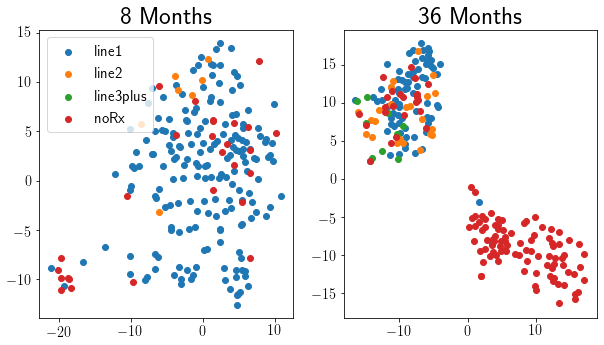

In [15]:
fig, axlist   = plt.subplots(1,2,figsize=(10,5.3))
ax    = axlist.ravel()
times = [4,18]
idxs  = [1,4]
for i,t in enumerate(times):
    result_CE = result_CEs[idxs[i]]
    a1 = np.where(An_obs[:,t,-3])[0]
    a2 = np.where(An_obs[:,t,-2])[0]
    a3 = np.where(An_obs[:,t,-1])[0]
    a4 = np.where((An_obs[:,t,-1]+An_obs[:,t,-2]+An_obs[:,t,-3]) == 0.)[0]
    a1g1= np.where(An_obs[:,t,-4]+An_obs[:,t,-3] == 2.)[0]
    a1g2= np.where(An_obs[:,t,-4] == 0.)[0]
    if i == 0: 
        ax[i].set_title(f'8 Months', fontsize=25)
    if i == 1: 
        ax[i].set_title(f'36 Months', fontsize=25)
#     ax[i].set_xlabel(f'dim 1', fontsize=20)
    if i == 1: 
#         sns.scatterplot(result_CE[a1g1,0],result_CE[a1g1,1], label = 'LEN (line1)', ax=ax[i])
#         sns.scatterplot(result_CE[a1g2,0],result_CE[a1g2,1], label = 'no LEN (line1)', ax=ax[i])
#         sns.scatterplot(result_CE[a2,0],result_CE[a2,1], label = 'line2', ax=ax[i])
#         sns.scatterplot(result_CE[a3,0],result_CE[a3,1], label = 'line3plus', ax=ax[i])
#         sns.scatterplot(result_CE[a4,0],result_CE[a4,1], label = 'noRx', ax=ax[i])
#         ax[i].scatter(result_CE[a1g1,0],result_CE[a1g1,1], label = 'LEN (line1)', s=36)
#         ax[i].scatter(result_CE[a1g2,0],result_CE[a1g2,1], label = 'no LEN (line1)', s=36)
        ax[i].scatter(result_CE[a1,0],result_CE[a1,1], label = 'line1', s=36)
        ax[i].scatter(result_CE[a2,0],result_CE[a2,1], label = 'line2', s=36)
        ax[i].scatter(result_CE[a3,0],result_CE[a3,1], label = 'line3plus', s=36)
        ax[i].scatter(result_CE[a4,0],result_CE[a4,1], label = 'noRx', s=36)
        ax[i].legend(loc='upper left', bbox_to_anchor=(-1.2,1.), fontsize=15)
    else: 
#         ax[i].scatter(result_CE[a1g1,0],result_CE[a1g1,1], s=36)
#         ax[i].scatter(result_CE[a1g2,0],result_CE[a1g2,1], s=36)
        ax[i].scatter(result_CE[a1,0],result_CE[a1,1], s=36)
        ax[i].scatter(result_CE[a2,0],result_CE[a2,1], s=36)
        ax[i].scatter(result_CE[a3,0],result_CE[a3,1], s=36)
        ax[i].scatter(result_CE[a4,0],result_CE[a4,1], s=36)
#         ax[i].set_ylabel('dim 2', fontsize=20)

    
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('./plots/aaai-plots/latent_tsne_2time.pdf',bbox_inches='tight')